# Facial Keypoint Detection
## Chandler McCann, Christopher Miller, Rohit Nair, Natarajan Shankar

Loading required packages.

## Troubleshooting tips for why lasagne library is not loaded
first "import theano", then "git clone https://github.com/Lasagne/Lasagne.git", followed by "cd Lasagne" and then "sudo -H python setup.py install"

# W207 Final Project Code

In [3]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/home/misko/.local/share/jupyter


In [4]:
import sys
sys.executable
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/bin/python3')
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')
sys.path.append('/home/misko/anaconda3')
sys.path.append('/home/misko/anaconda3/lib/python3.5/site-packages')

In [5]:
# Telling matplotlib to plot graphs inline
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import time
from matplotlib import cm

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import theano
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import _pickle as pickle

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)
/home/misko/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# STEP 1: UNDERSTAND THE PROBLEM
### 1. The goal is to detect 15 different keypoints on the face
### 2. 7049 training samples are available, some have NaN in attribute fields, needs to be cleaned up
### 3. Once cleaned up data is available, study the cleaned up data to see whether cleanup added value
### 4. Run PCA to narrow down the dimensionality
### 5. With narrowed dimensionality, train and predict using Neural nets 

# STEP 2: LOAD THE DATA AND DO BASIC CLEANUP

Loading train data and getting some information about its structure.

In [6]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

def load(test=False, cols=None, logging=True):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    # Just for the visual record, have the data printed out
    print(df.count())  # prints the number of values for each column
 
    # Get all the rows that have some NA fields
    dfna = df[df.isnull().any(axis=1)]

    # For the first level of processing, use only the records that have
    # complete data (no NaN)
    df = df.dropna()  # drop all rows that have missing values in them

    # Stick to 4 decimal points in order to have well formatted output
    # There are 2 dataframes
    #    df - dataframe with complete data
    #    dfna - dataframe with records that have NaN
    df.round(4)
    dfna.round(4)
    
    # Return processed data and the 2 dataframes
    return df, dfna


# Load the data
train_df, train_dfna = load()
test_df, test_dfna = load(test=True)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Additional Cleanup
### Dealing with rows that have NAs
#### 1. 4909 rows have NAs in some fields. These rows otherwise carry important information and this information in other columns must somehow be used. 
#### 2. 2140 rows have complete information and can used as a training set.
#### 3. The the field averages from the complete set and use the field averages to fill in and complete the set with NaNs
#### 4. This approach will provide a full 7049 rows if data that can be used for building predictive models.

In [7]:
# If true, program attempts to fix images with missing keypoints
include_errors = False

def repair_dataset(train_df=train_df, train_dfna=train_dfna, logging=True): 
    # How many rows have null features exist?
    dfnacheck_before = len(train_dfna[train_dfna.isnull().any(axis=1)])
    if (logging==True):
        print("Rows with NA features before cleanup: %d" % dfnacheck_before)

    # Now compute the average of every column and use the averages to fill in the NaN fields in dfna
    for feature in train_dfna:
        if feature != 'Image':
            mean = train_df[feature].mean() * 1.0
            train_dfna[feature] = train_dfna[feature].fillna(mean)

    # Assert that all null features have been dealt with.
    dfnacheck_after = len(train_dfna[train_dfna.isnull().any(axis=1)])
    assert(dfnacheck_after == 0)
    if (logging==True):
        print("Rows with NA features after cleanup: %d" % dfnacheck_after)

    # Merge the df and dfna dataframes together to create a much larger data set
    #repaired = pd.concat([train_df, train_dfna])
    repaired = train_df.append(train_dfna)

    if (logging==True):
        print("Size of corrected dataset: %d" % len(repaired))
    return repaired

# Finish creating the data
def get_data(df, test=False, col=None, logging=True):
    if logging==True:
        print(df.count())
    
    # Normalize the given data
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48 # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        
    else:
        y = None
    return X, y

if include_errors == True:
    repaired_df = repair_dataset()
    train_data, train_labels = get_data(repaired_df, logging=False)
else:
    train_data, train_labels = get_data(train_df, logging=False)
test_data, test_labels = get_data(test_df,test=True, logging=False)

# Print out data boundaries
print("train_data.shape == {}; train_labels.min == {:.3f}; train_labels.max == {:.3f}".format(
        train_data.shape, train_data.min(), train_data.max()))
print("train_labels.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
        train_labels.shape, train_labels.min(), train_labels.max()))

train_data.shape == (2140, 9216); train_labels.min == 0.000; train_labels.max == 1.000
train_labels.shape == (2140, 30); y.min == -0.920; y.max == 0.996


## For data visualization, need a plot routine
### Copy the plot code as published in 
https://www.ischool.berkeley.edu/sites/default/files/projects/14-dailey_jang_oneto_yang_final.pdf

Display some sample images with their keypoints:


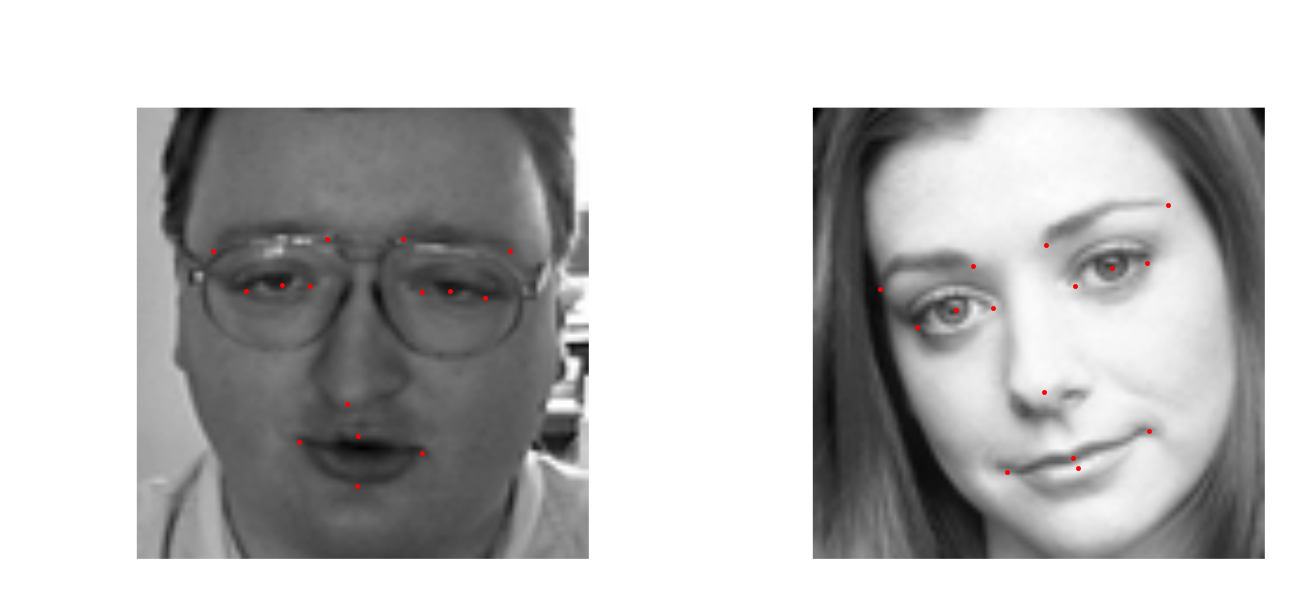

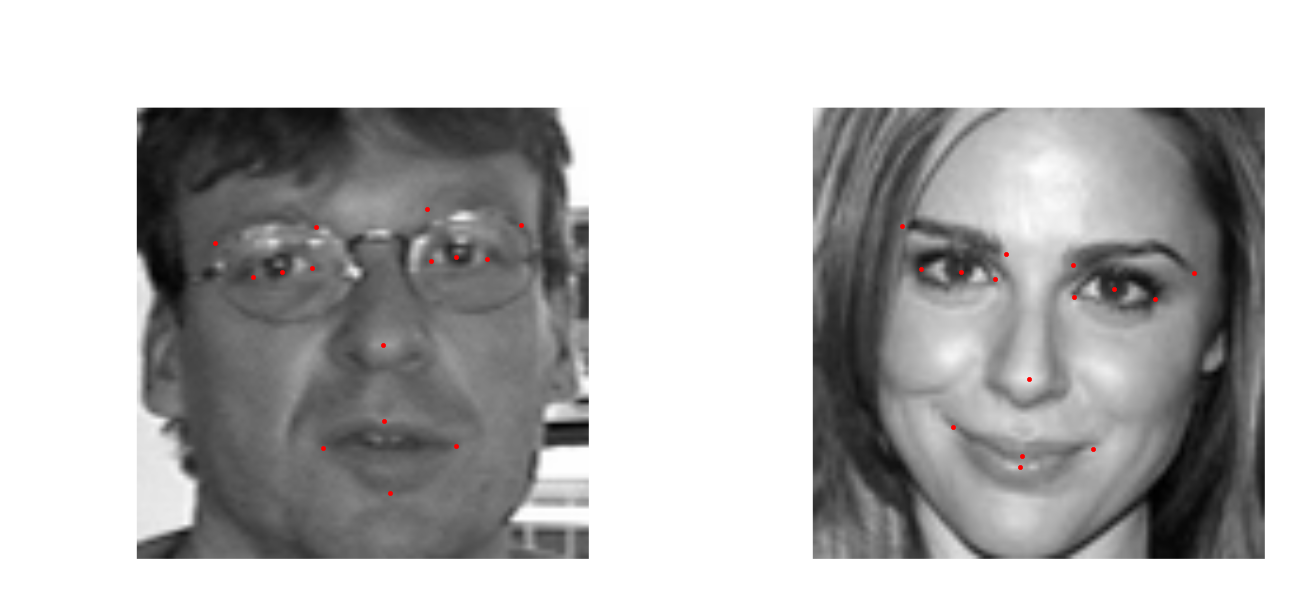

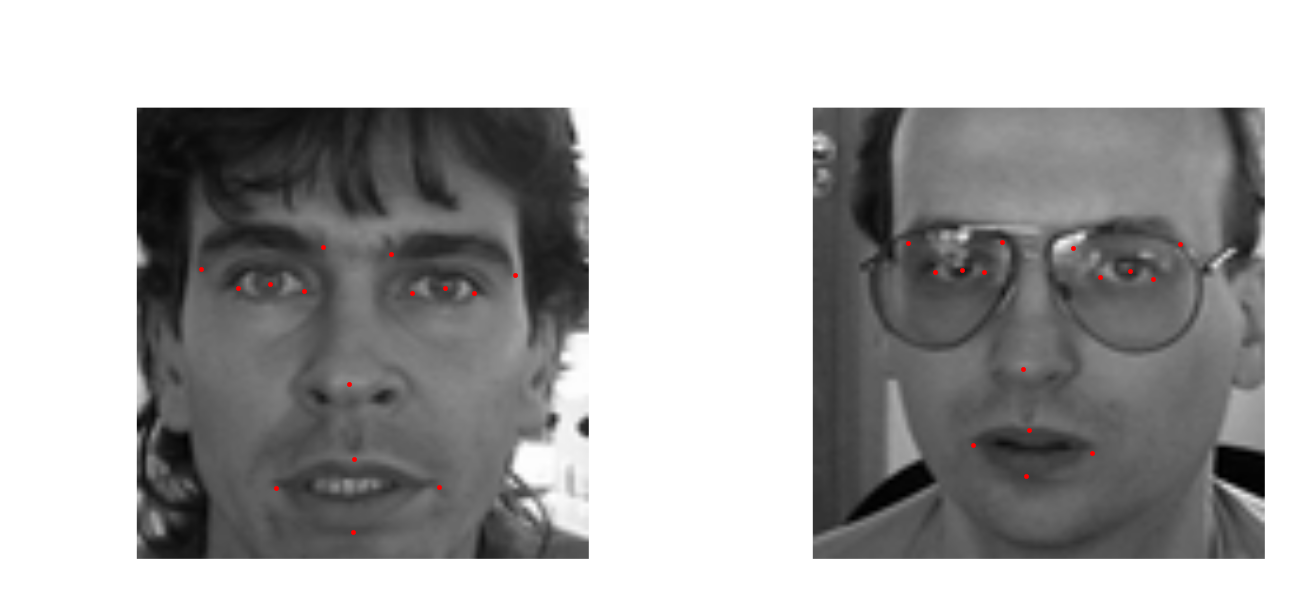

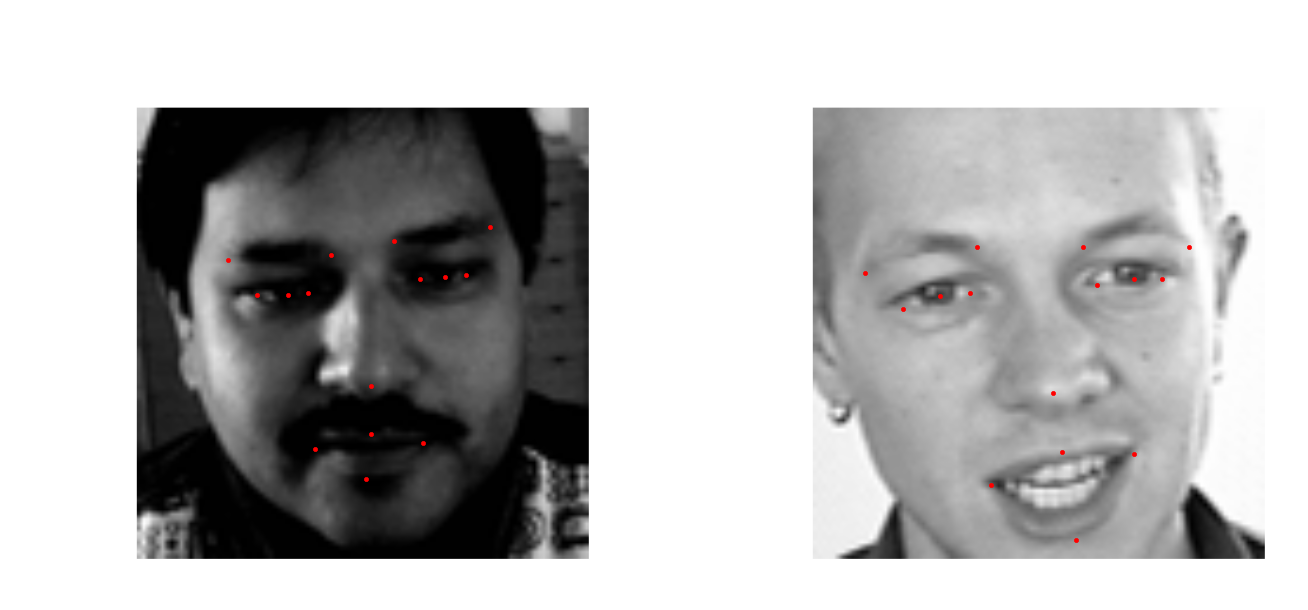

In [8]:
def compare_images(image1, p1, image2, p2): 
    p1 = p1 * 48 + 48
    p2 = p2 * 48 + 48
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1) 
    plt.imshow(np.reshape(image1,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p1,(len(p1)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')
    plt.subplot(1,2,2) 
    plt.imshow(np.reshape(image2,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p2,(len(p2)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')

# Keep data consistent.
np.random.seed(0)
sample = np.floor(np.random.rand(5, 2) * len(train_data))

print("Display some sample images with their keypoints:")
for i in sample:
    compare_images(train_data[i[0]], train_labels[i[0]], train_data[i[1]], train_labels[i[1]])


## STEP 3 : Start with a simple neural network to predict 

Plotting how well the neural net works with no preprocessing by looking at training loss.


In [ ]:
def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-3, 1e-2)
    plt.yscale("log")
    plt.show()

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=1000,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(train_rotated.astype(np.float32), labels_rotated.astype(np.float32))
graph_results(net1)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00265) * 48))

# Data Adjustment: Algorithm # 1
### Histogram Stretching
A simple way of image enhancement that improves the contrast in an image by stretching the range of pixel intensity to span the entire range from minimum (0) to maximum (1). Over 8 bits, this algorithm expands the contrast in the image over the entire 0 to 255 range

The reference article is:
http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf
#### Ref: Facial Keypoints Detection, by Yue Wang and Yang Song, Stanford University

Finished stretching sample train_data map in 0.000112 seconds
Starting stretching of all data
Finished stretching all in 282.311886 seconds


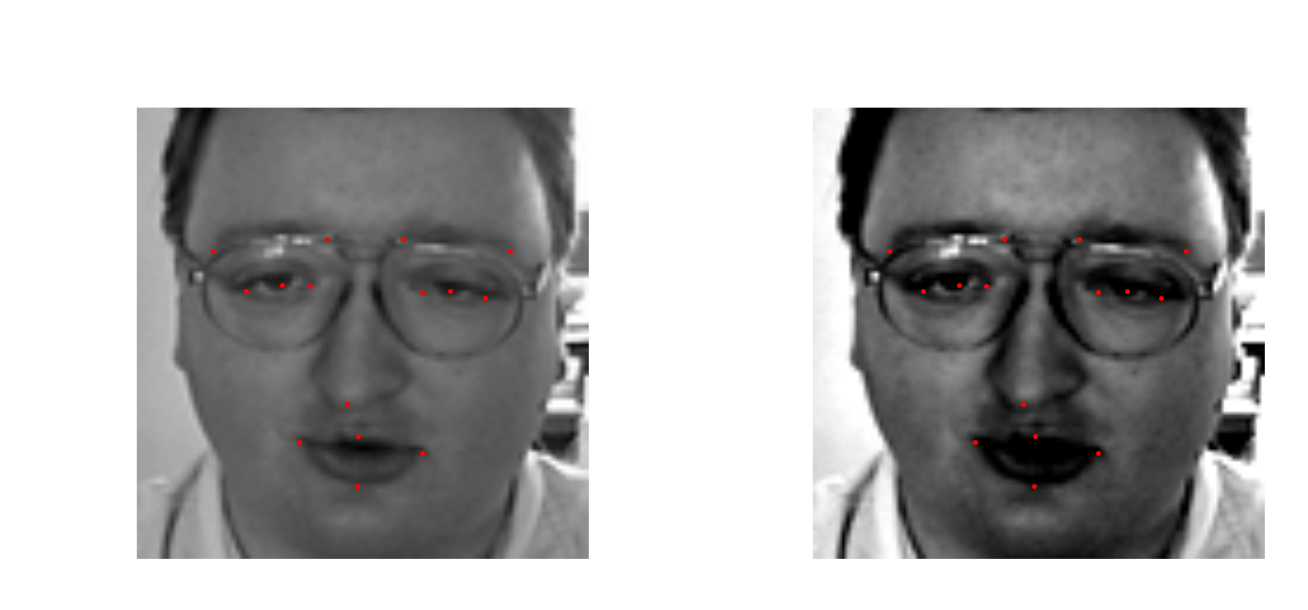

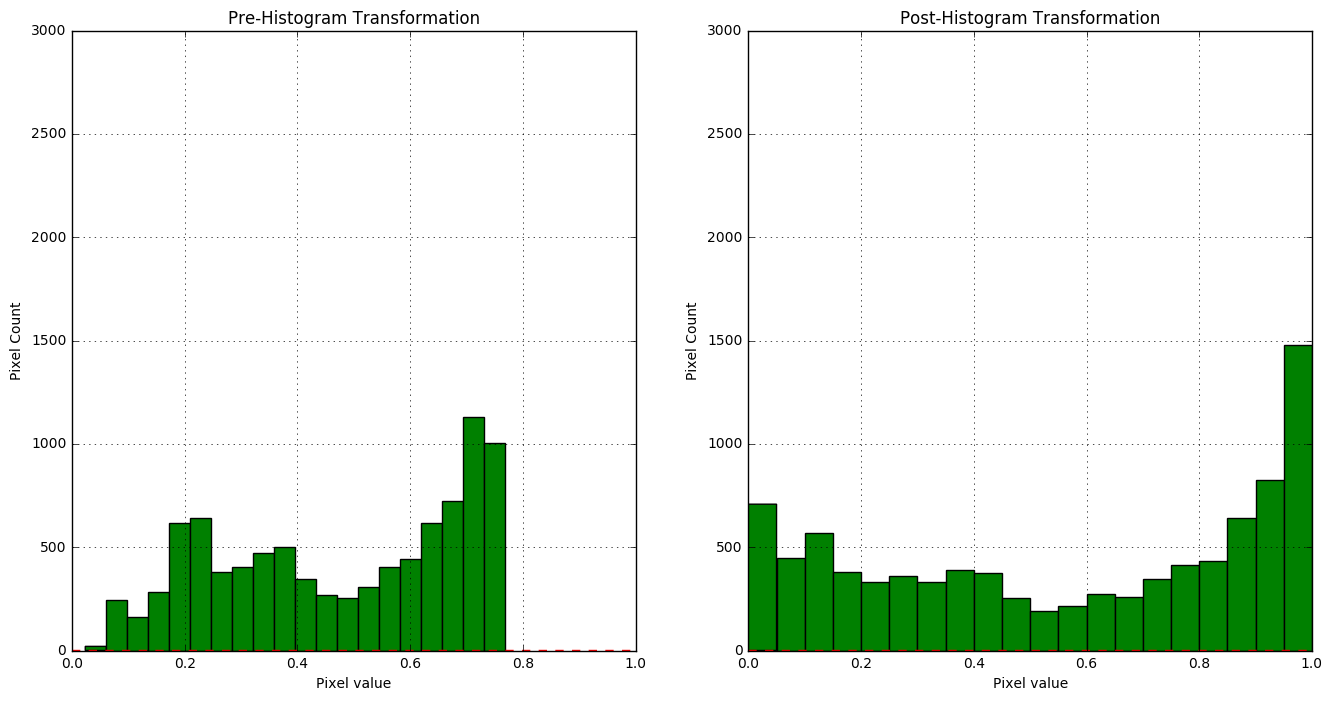

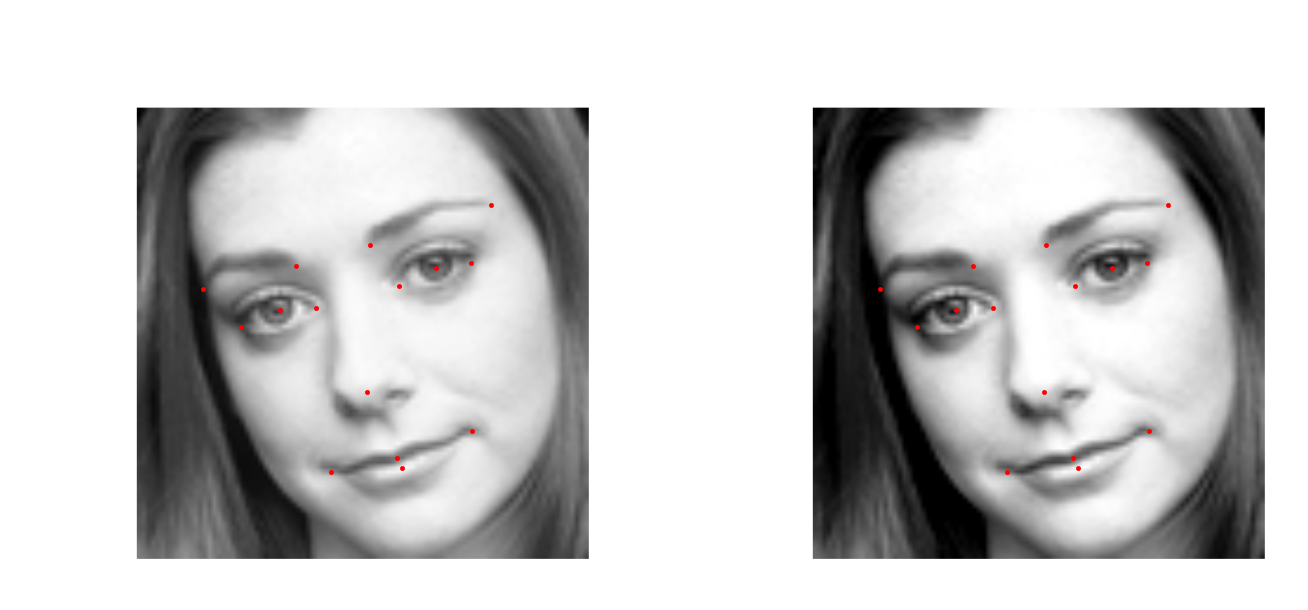

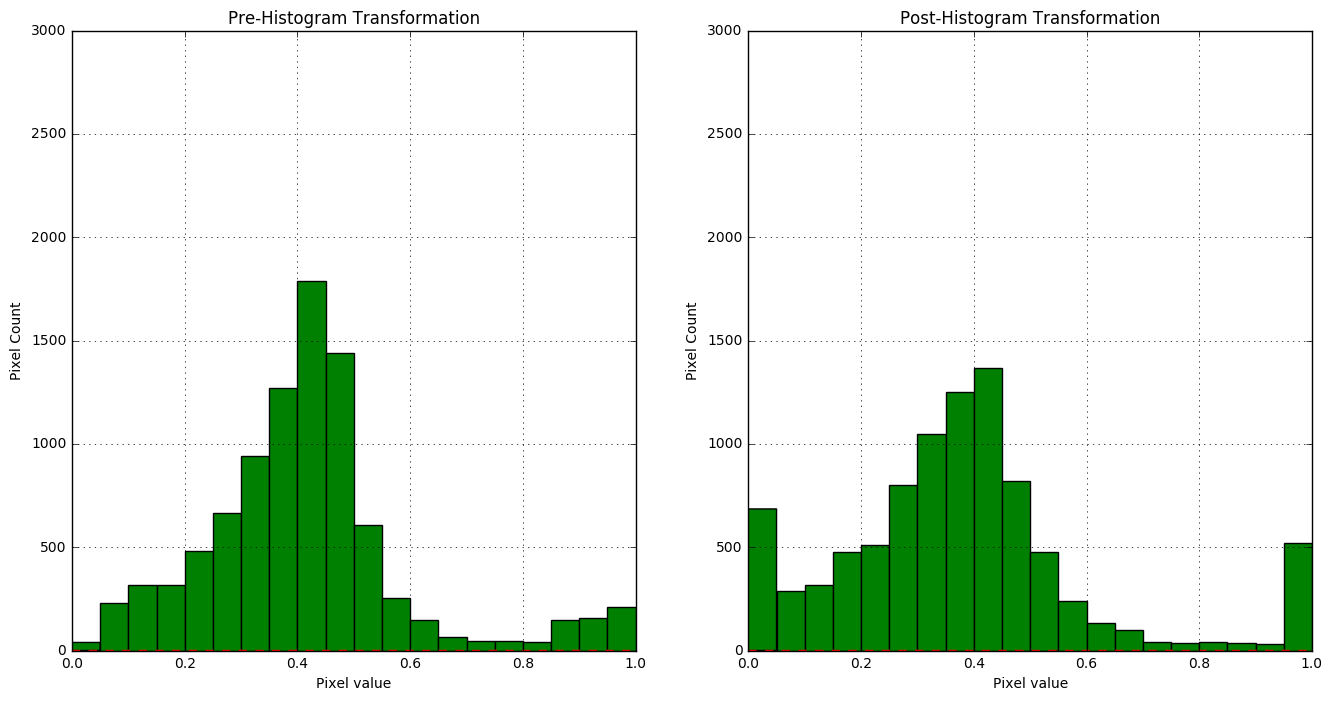

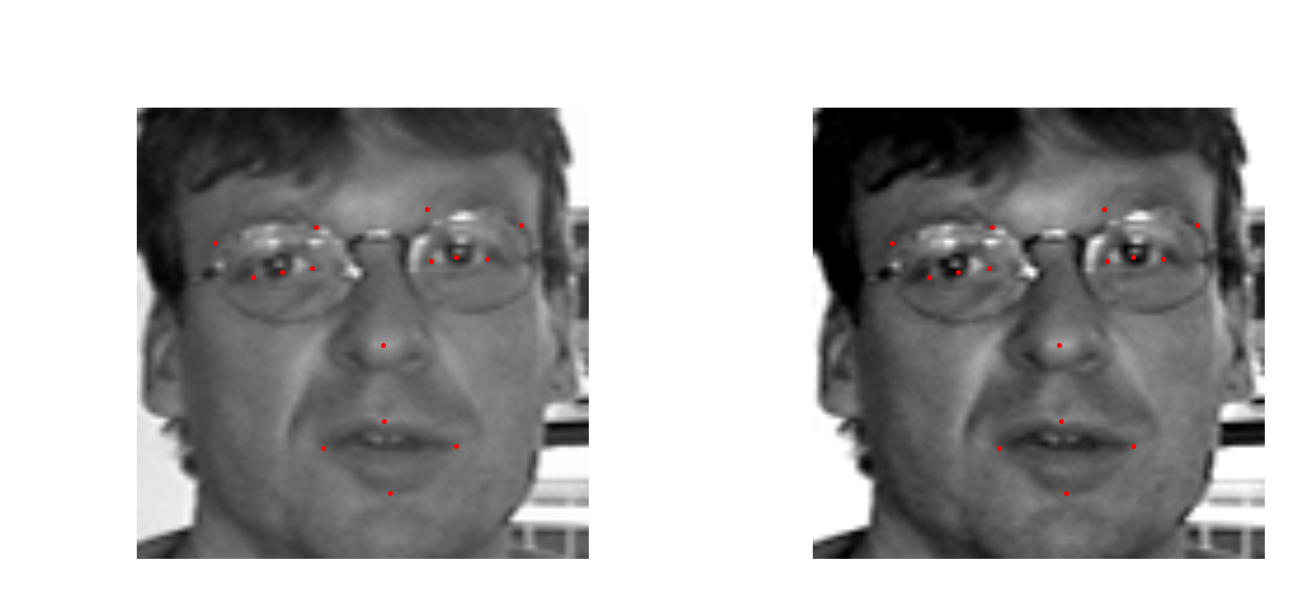

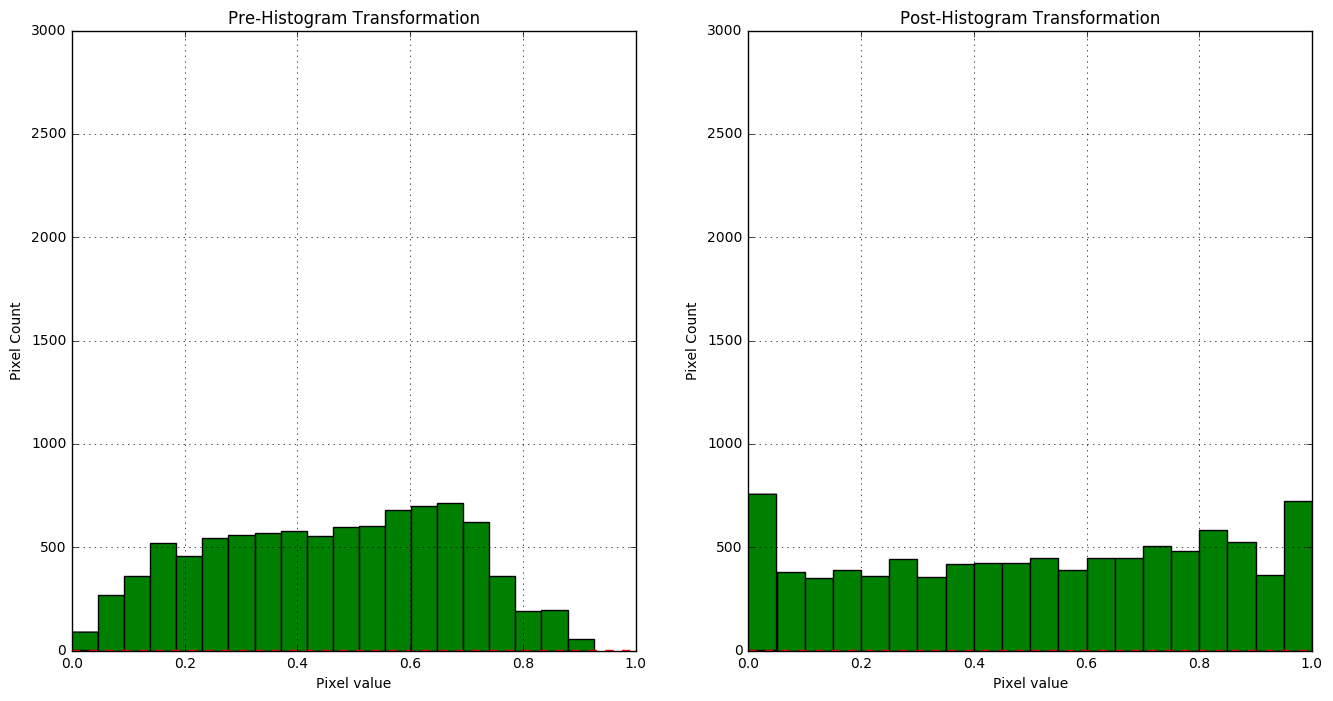

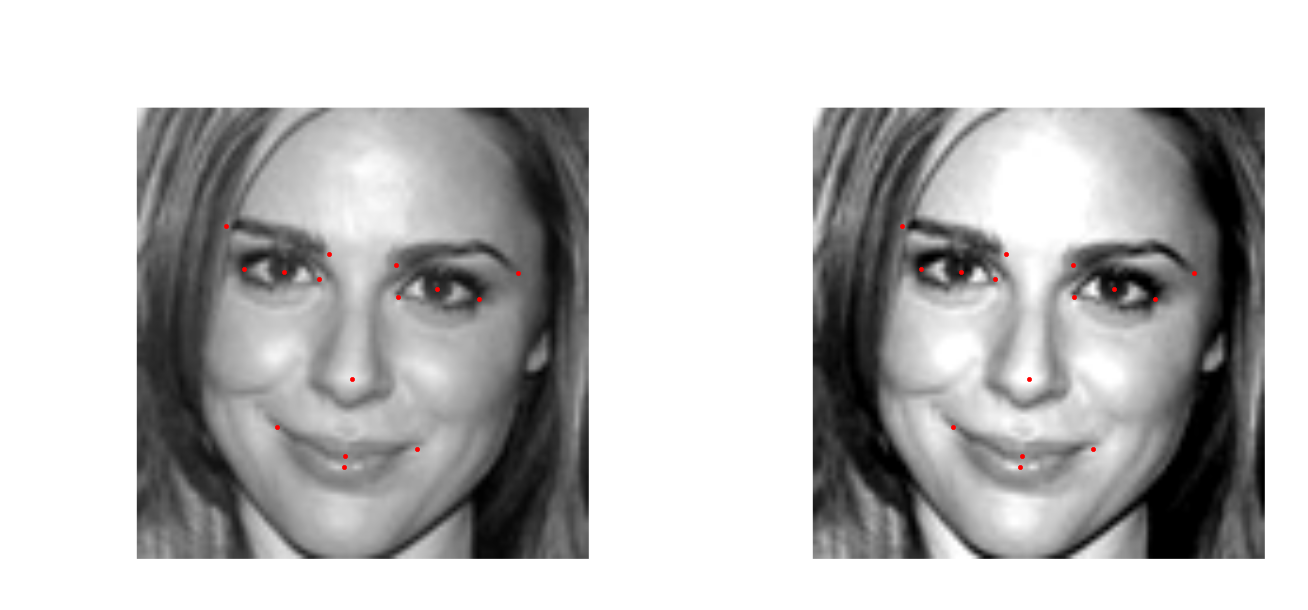

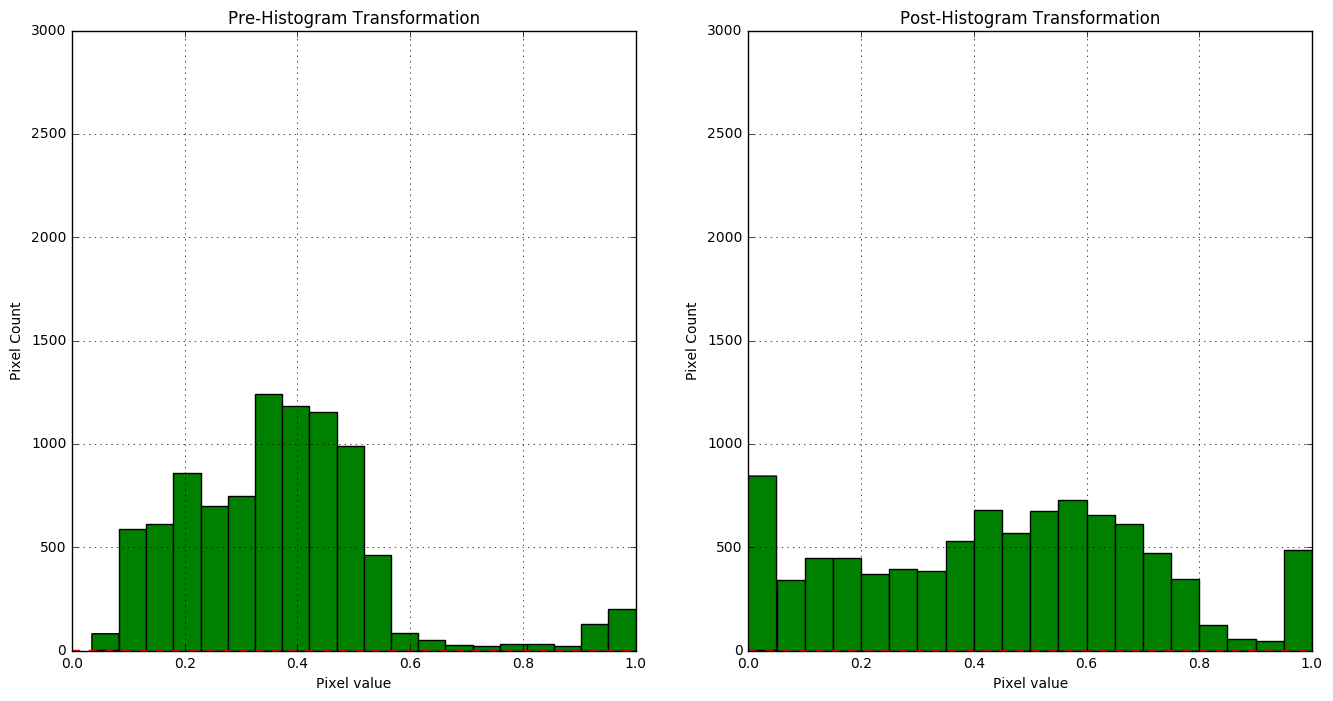

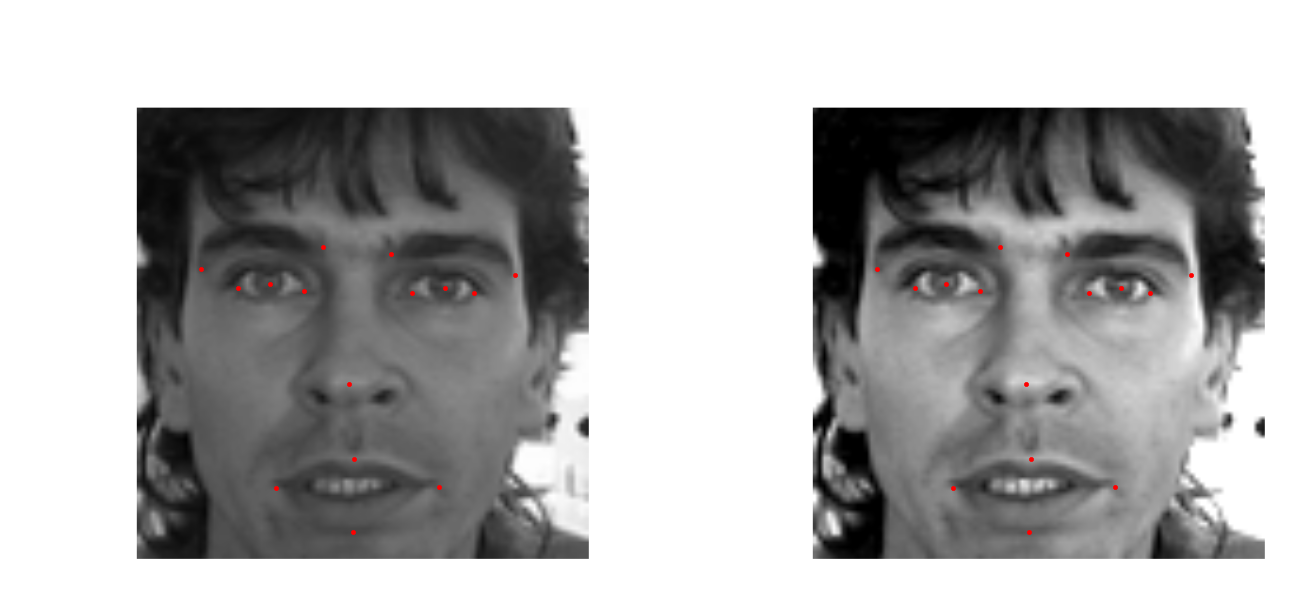

In [9]:
def compare_histograms(frame1, frame2):
        fig = plt.figure(figsize=(16,8))
        # the histogram of the data
        fig.add_subplot(1,2,1)
        n, bins, patches = plt.hist(frame1, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Pixel Count')
        plt.title('Pre-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)

        fig.add_subplot(1,2,2)
        n, bins, patches = plt.hist(frame2, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Pixel Count')
        plt.title('Post-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)


def stretch_histogram(frame):
    # Save the incoming 
    new_frame = []
    
    # Algorithm is very sensitive to outliers at both ends
    # So, focus on the 5th and 95th percentile points as as proposed by Song et al.
    a = np.percentile(frame, 5)
    b = np.percentile(frame, 95)
    u = 1 # desired_max_pixel_value
    l = 0 # desired_min_pixel_value

    # Algorithm fails to optimize if low and high values are at the extreme
    if a == 0 and b == 1:
        return(frame)
    
    # If frame is all white or all black, skip processing
    if a == 1 or b == 0:
        return(frame)

    for x in range(0, len(frame)):
        if (frame[x] > b):
            new_frame.append(np.float32(1.0))
        elif (frame[x] < a):
            new_frame.append(np.float32(0.0))
        else:
            p_prime = np.float32(((u - l) / (b - a)) * (frame[x] - a) - l)
            new_frame.append(p_prime)
            if (p_prime < 0) | (p_prime > 1):
                pass
                #print(x, p_prime)
    
    return np.array(new_frame).astype(np.float32)

# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(5) * len(train_data)

for i in sample:
    before = train_data[i]
    after = stretch_histogram(train_data[i])
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])


# For python v2
start = time.time()
train_stretched = np.array(map(stretch_histogram, train_data))
print("Finished stretching sample train_data map in %4f seconds" % (time.time() - start))


# For python v3
# Routine to stretch all histograms in training data
def stretch_histogram_all(train_data=train_data):
    train_hist_stretch = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_hist_stretch[index] = np.array(stretch_histogram(train_data[index]))
    return np.array(train_hist_stretch)

start = time.time()
print("Starting stretching of all data")
train_hist_stretch = stretch_histogram_all()
print("Finished stretching all in %4f seconds" % (time.time() - start))


## Testing improvement with Histogram Stretching

See how the model improved by increasing contrast

In [ ]:
net2 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(train_stretched, train_labels)

graph_results(net2)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00373) * 48))

## Data Adjustment: Algorithm # 2
### Histogram Shifting
A simple way of image enhancement that improves the contrast in an image by shifting the intensity of the pixels to the right. Lighter pixels are darker and darker pixels are enhanced. 
The reference article is: www.tutorialspoint.com

Finished shifting RIGHT train_data in 0.000106 seconds
Finished shifting LEFT train_data in 0.000104 seconds
Starting shift right of all data
Finished shifting all right in 61.958856 seconds
Starting shift left of all data
Finished shifting all left in 60.982100 seconds


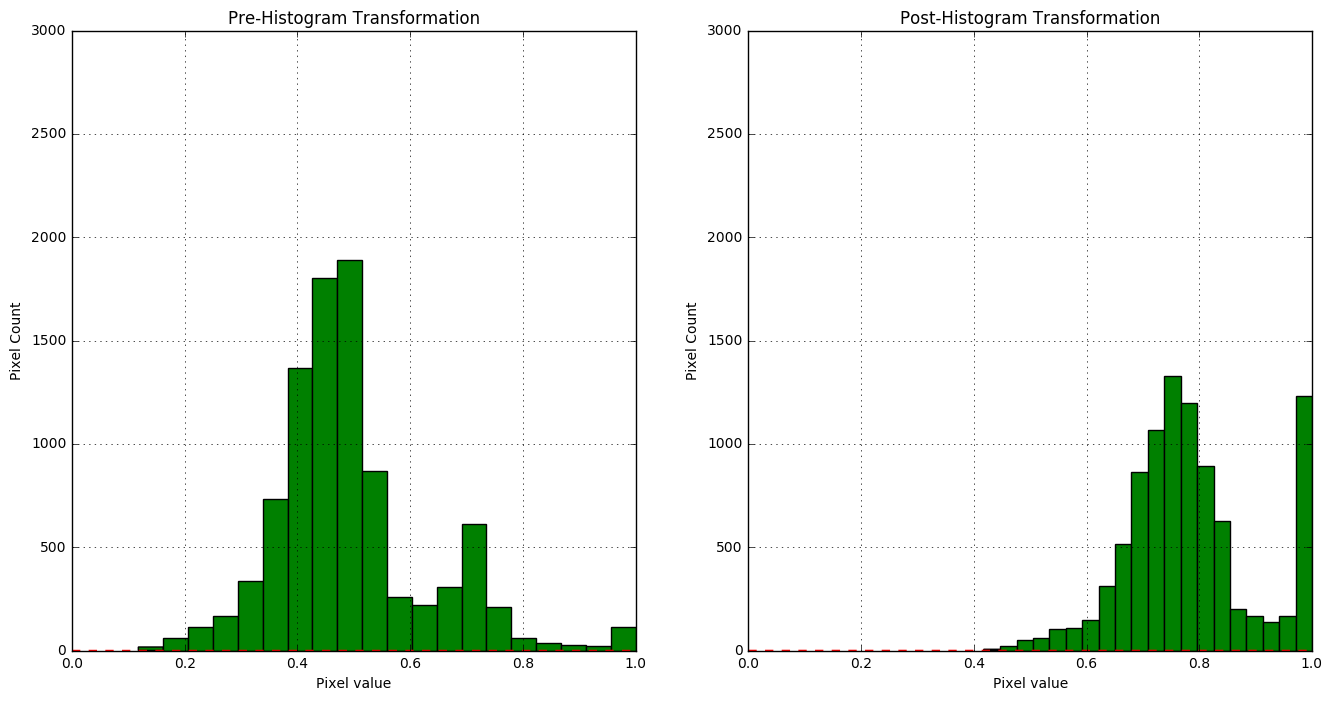

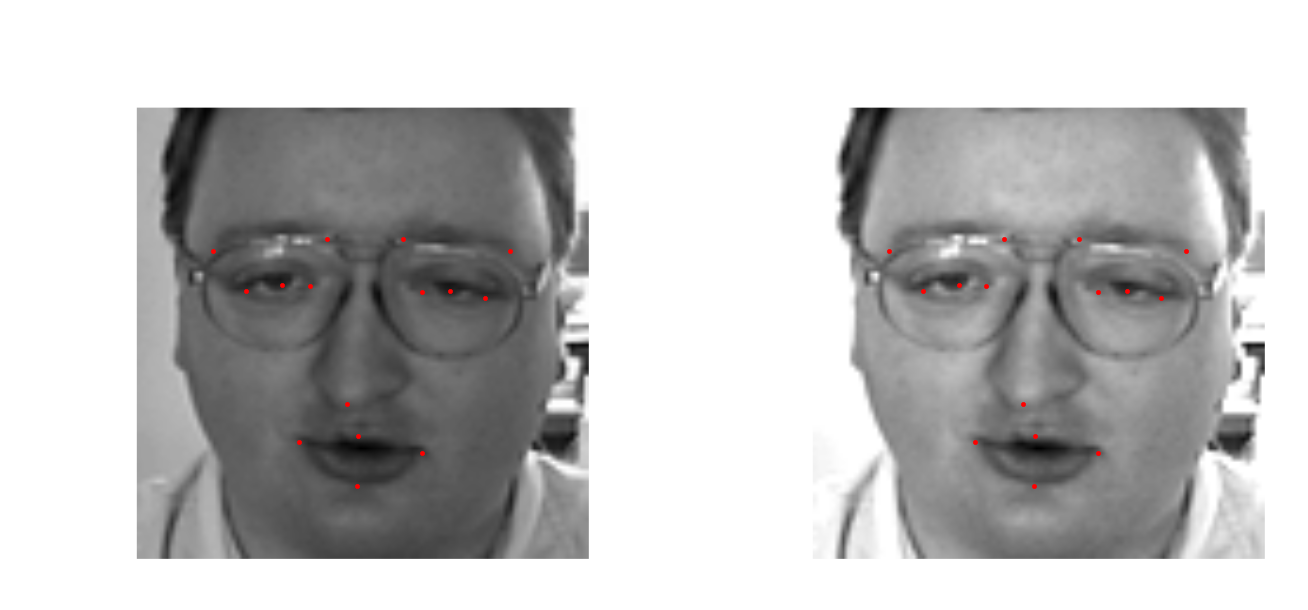

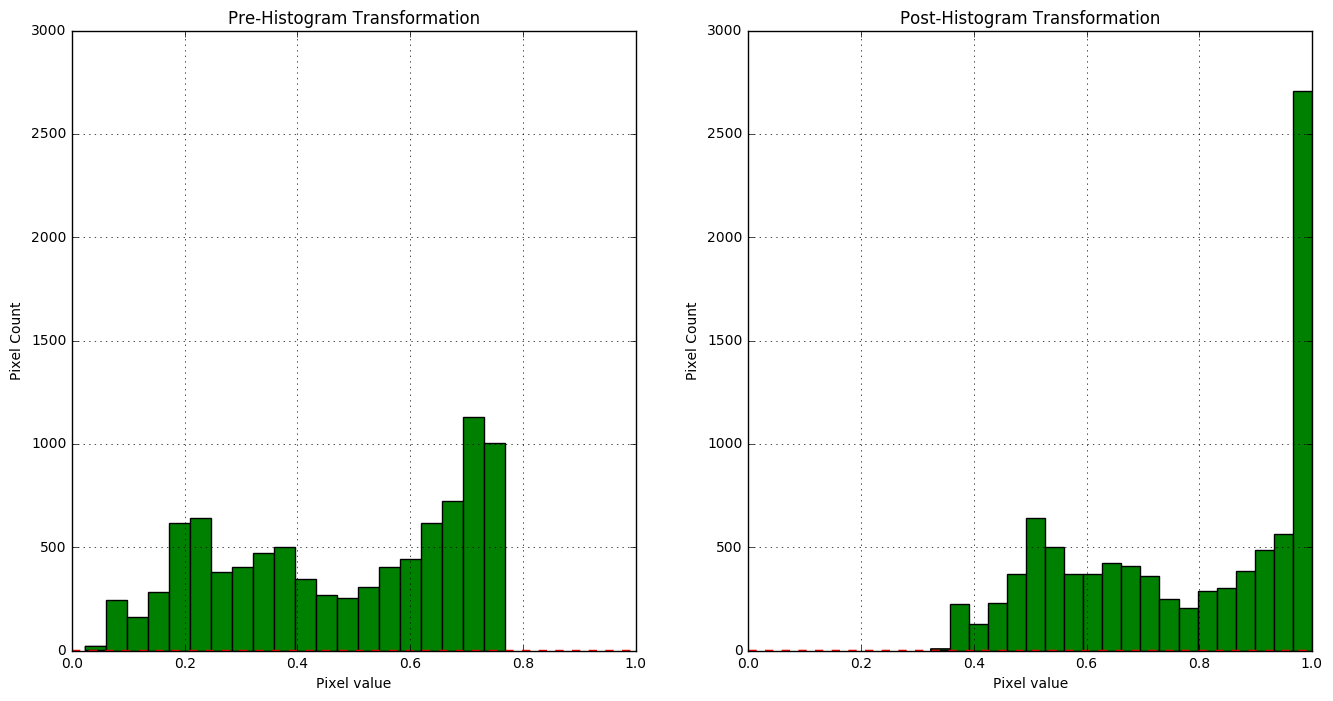

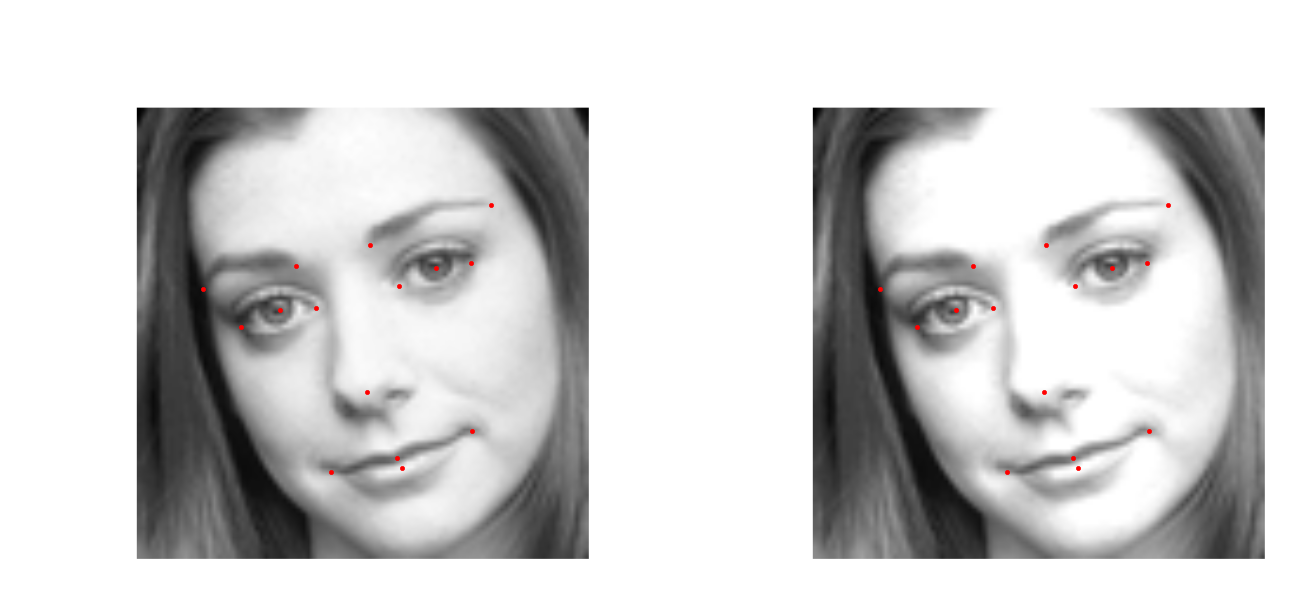

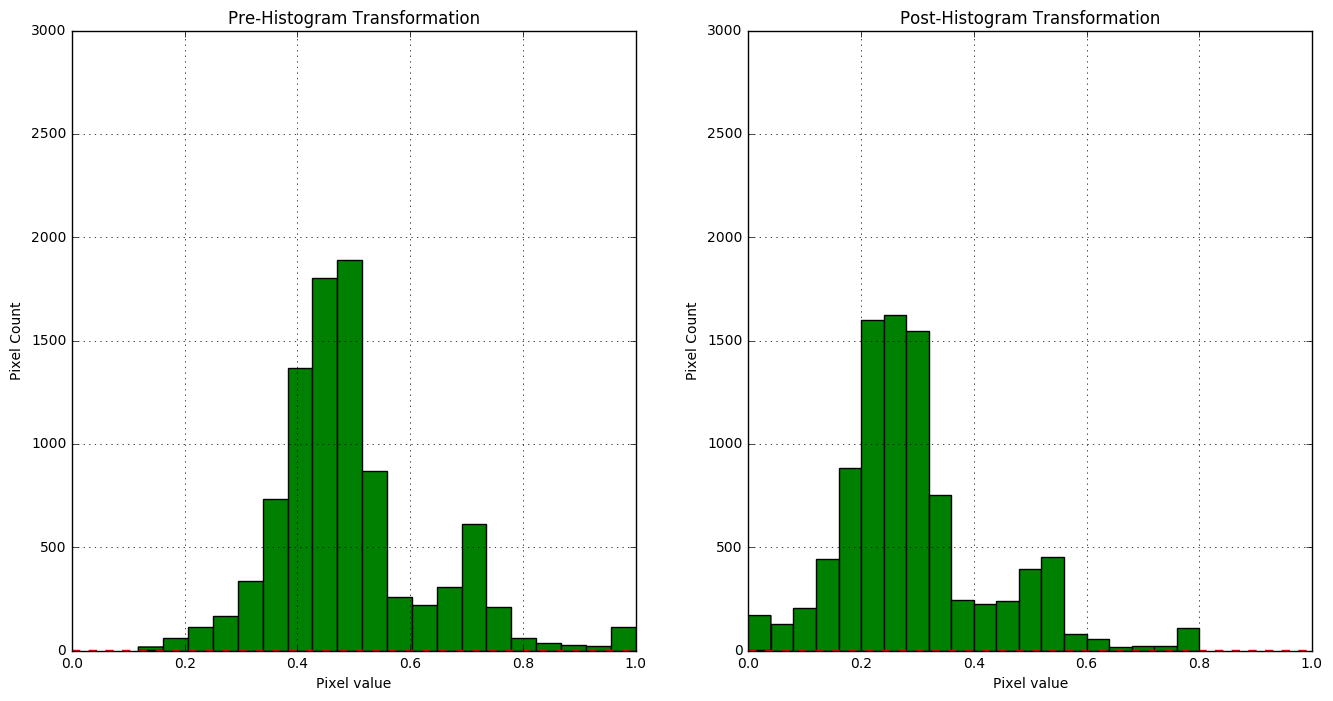

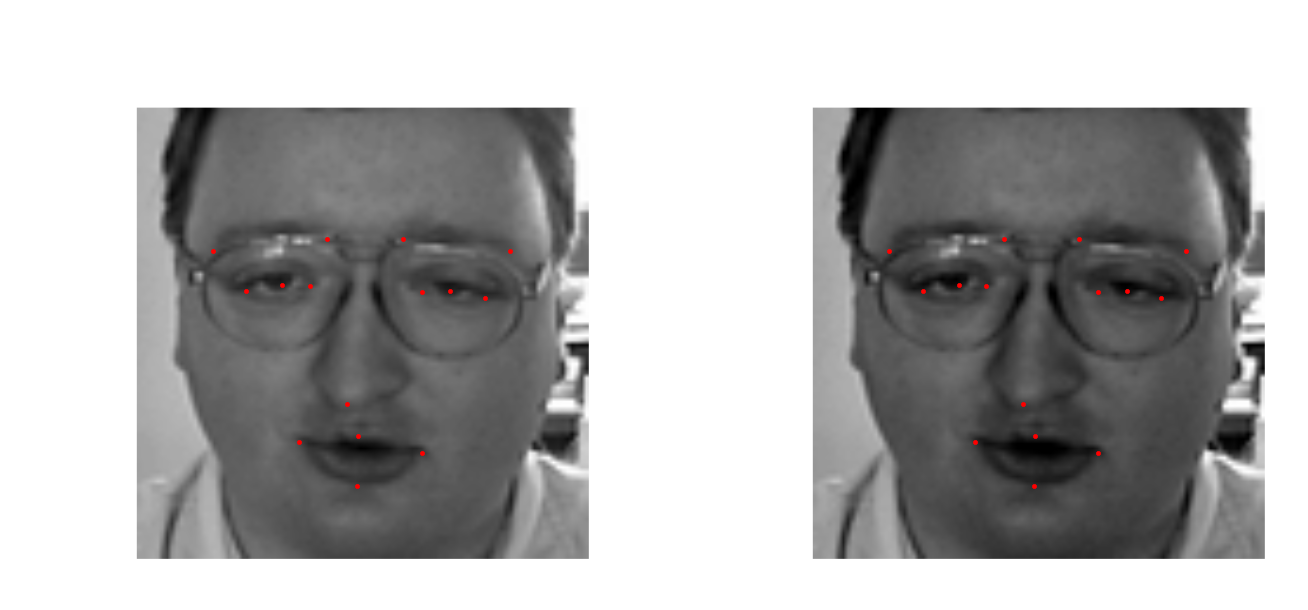

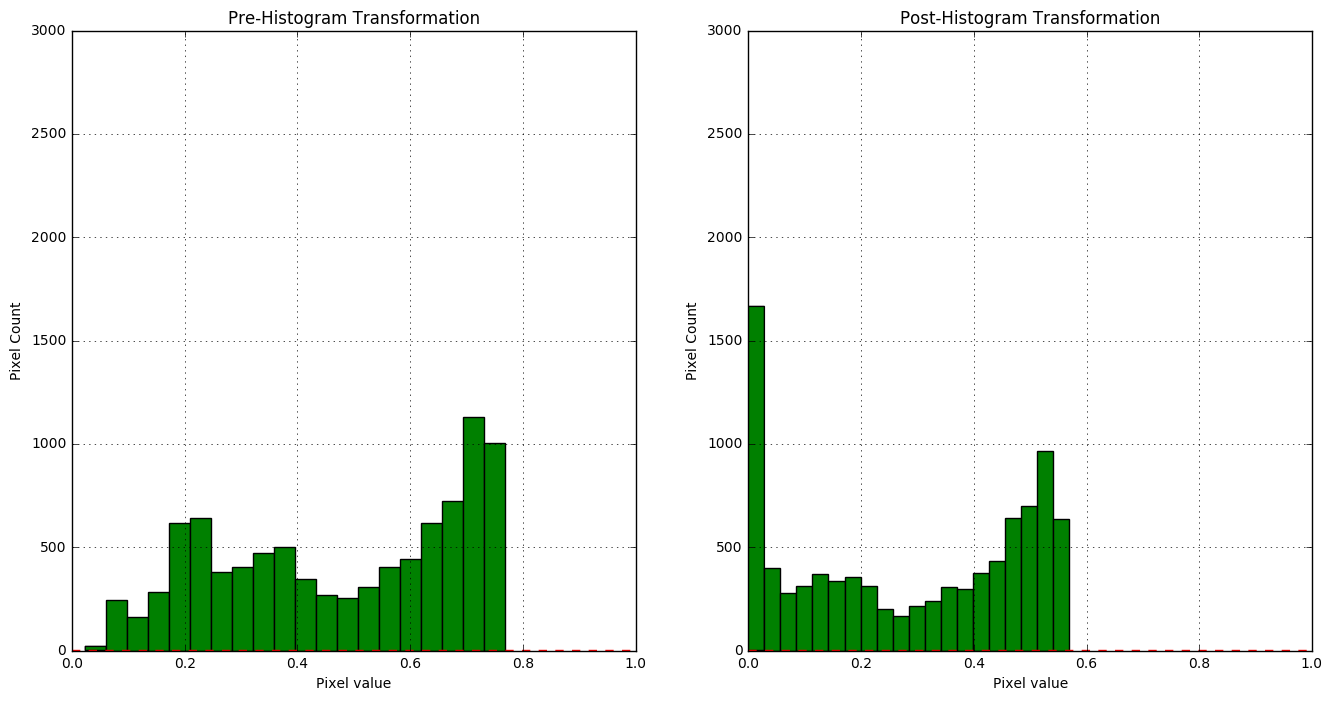

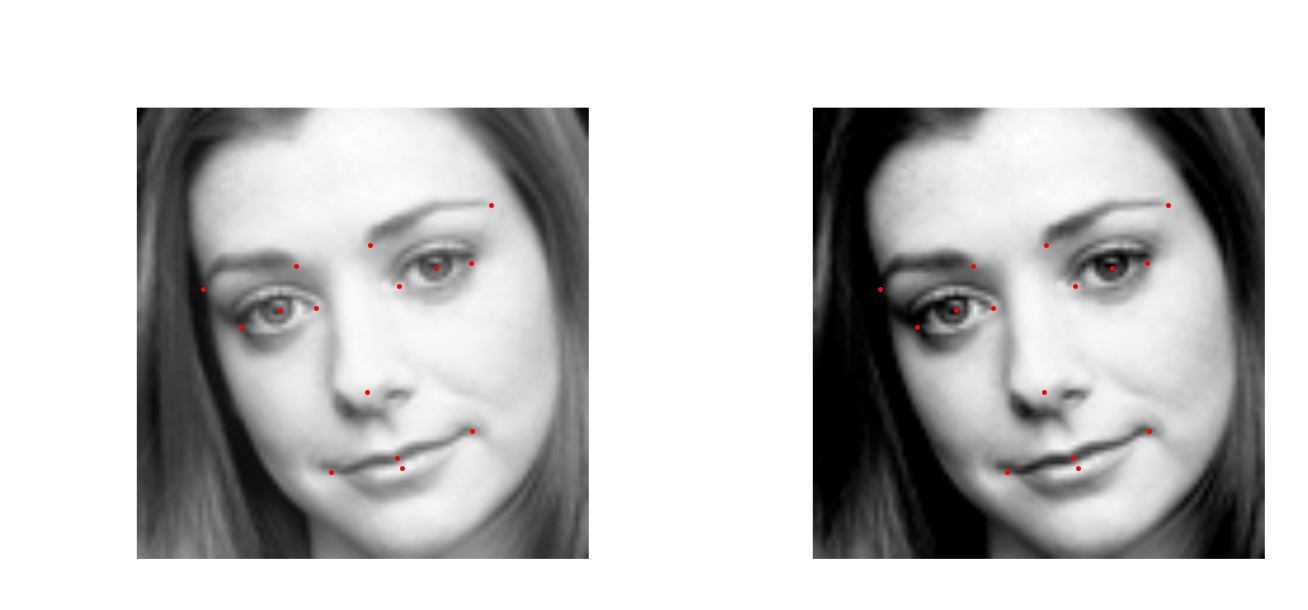

In [11]:
# Load data and shift
def shift_histogram_right(frame, shift=0.3):
    
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] + shift
        if new_value > 1.0:
            new_frame.append(np.float64(1.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of right shift
r_shift = 0.30


for i in sample:
    before = train_data[i]
    after = shift_histogram_right(train_data[i], shift=r_shift)
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()

train_shift_right = np.array(map(shift_histogram_right, train_data))
print("Finished shifting RIGHT train_data in %4f seconds" % (time.time() - start))

# Load data and shift
def shift_histogram_left(frame, shift=0.2):
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] - shift
        if new_value < 0.0:
            new_frame.append(np.float64(0.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of left shift
l_shift = 0.2

for i in sample:
    before = train_data[i]
    after = shift_histogram_left(train_data[i], shift=l_shift)
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()


train_map_shift_left = np.array(map(shift_histogram_left, train_data))
#train_shift_left = np.array(map(shift_histogram, train_data))
print("Finished shifting LEFT train_data in %4f seconds" % (time.time() - start))


# For python v3
# Routine(s) to shift all histograms in training data
def shift_histogram_right_all(train_data=train_data):
    train_shift_right = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_shift_right[index] = np.array(shift_histogram_right(train_data[index]))
    return np.array(train_shift_right)

def shift_histogram_left_all(train_data=train_data):
    train_shift_left = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_shift_left[index] = np.array(shift_histogram_left(train_data[index]))
    return np.array(train_shift_left)


start = time.time()
print("Starting shift right of all data")
train_shift_right = shift_histogram_right_all()
print("Finished shifting all right in %4f seconds" % (time.time() - start))
start = time.time()
print("Starting shift left of all data")
train_shift_left = shift_histogram_left_all()
print("Finished shifting all left in %4f seconds" % (time.time() - start))

## Testing improvement with Histogram Shifting

See how the model improved by increasing brightness


In [ ]:
print(len(train_shift_left))

In [ ]:
net3 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net3.fit(train_shift, train_labels)
graph_results(net3)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00384) * 48))

## More augmentation

### Gaussian Blur

Gaussian Blur changes cell values to a weighted average of surrounding cells.  

Finished blurring train_data in 0.000103 seconds
starting blurring of all frames
Finished blurring all train_data in 636.171955 seconds


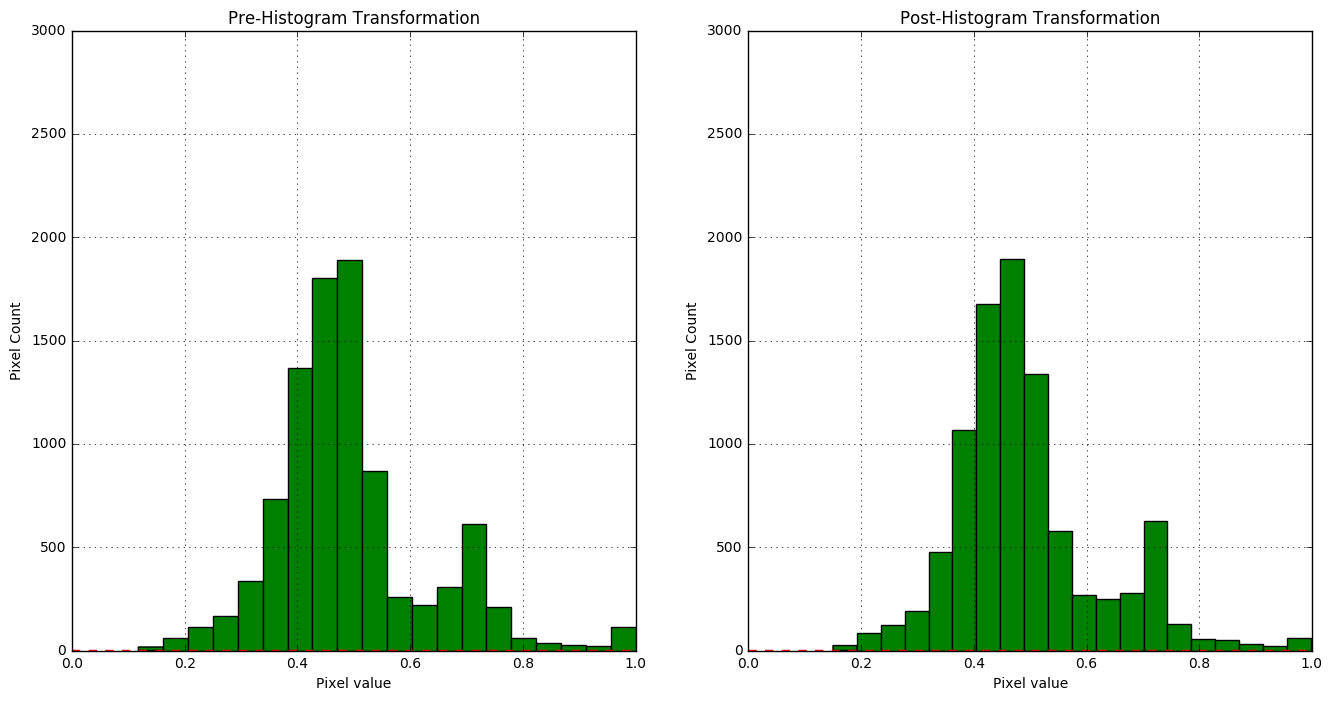

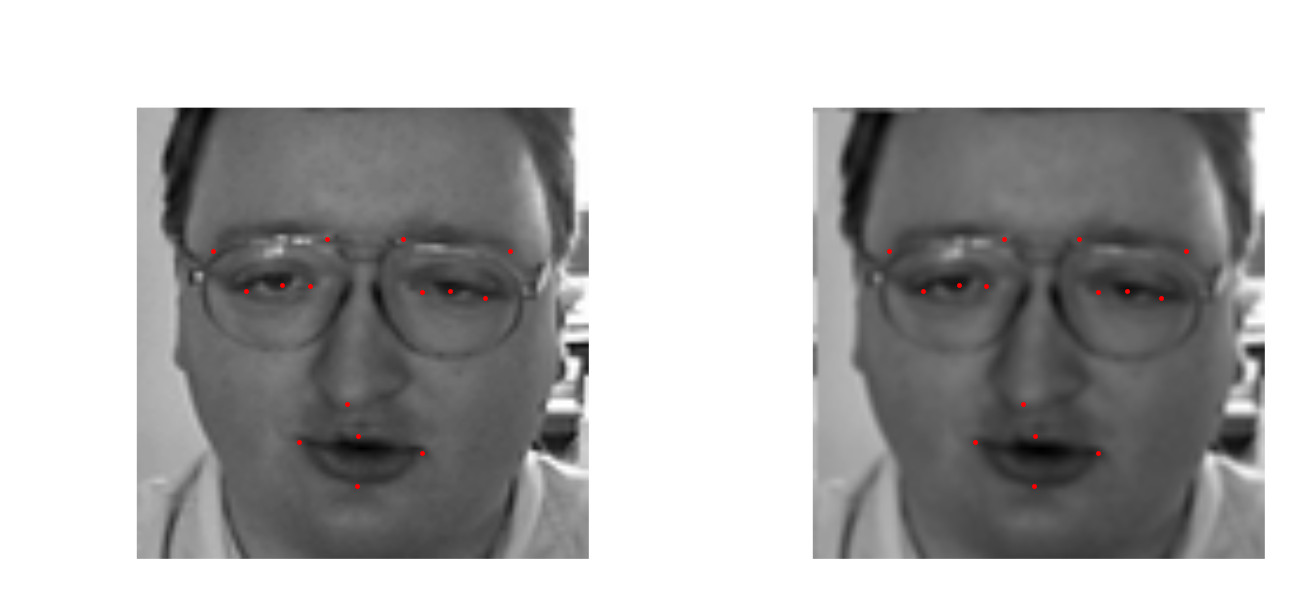

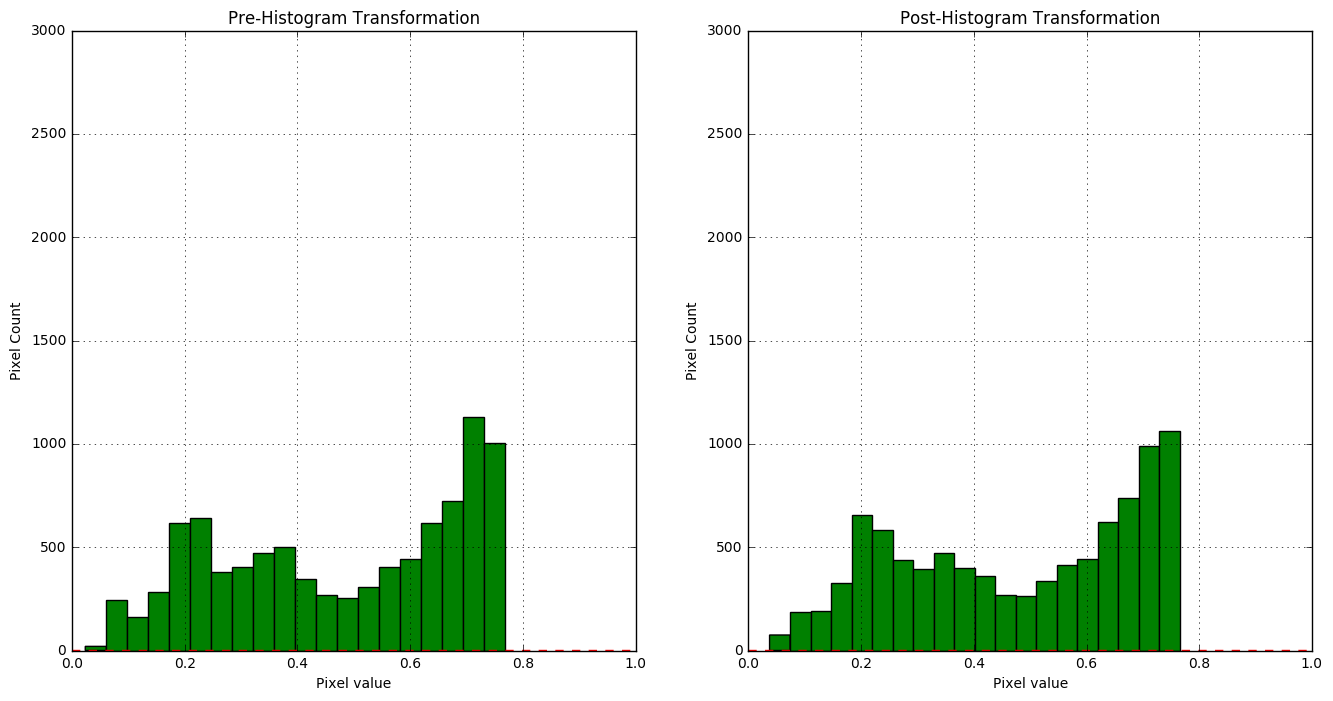

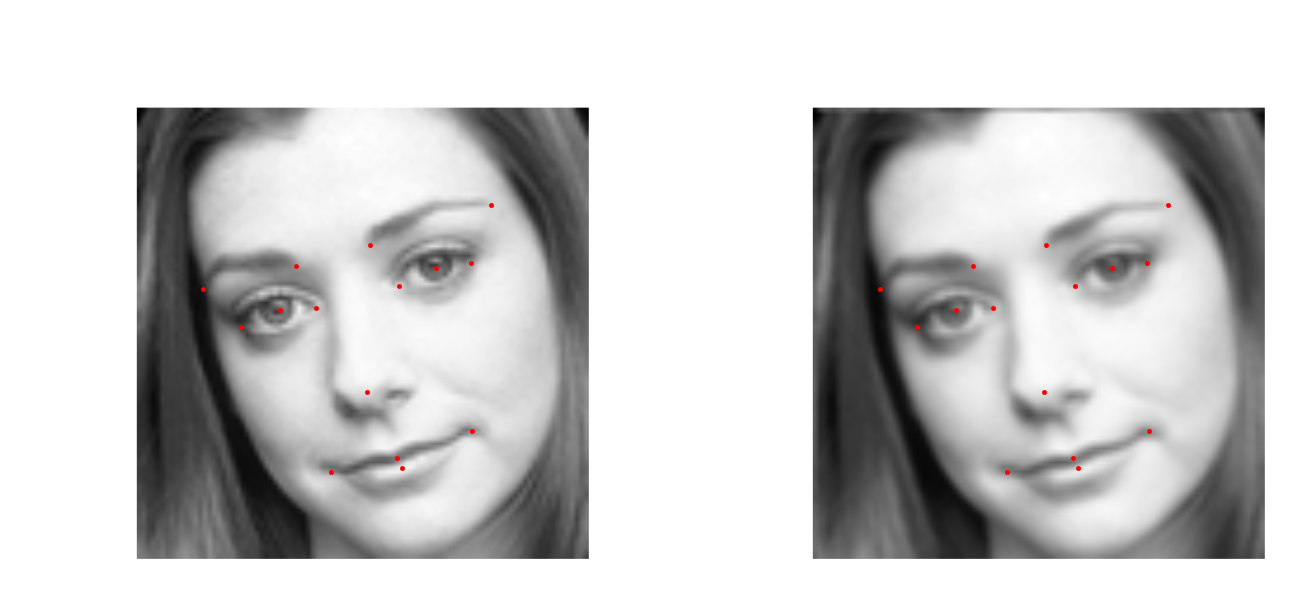

In [12]:
def gaussian_blur(origin, matrix, blur=1):
    sd = 2
    pi = np.pi
    e = np.e
    cartesian = []
    coords = []
    weights = []
    blurred_pixel = 0.0

    x = origin[0]
    y = origin[1]
    
    for i in range(-blur, blur):
        for j in range(-blur, blur):
            cartesian.append([i, j])
            try:
                if ((x - i) == 0) | ((y - j) == 0):
                    raise IndexError
                coords.append(matrix[x + i][y + j])
            except IndexError:
                coords.append(matrix[x][y])
    weights = []
    for pair in cartesian:
        x = pair[0]
        y = pair[1]
        weight = (1.0 / (2 * pi * sd ** 2)) * (e ** -((x ** 2 + y ** 2) / (2 * sd ** 2))) # 2D Gaussian function
        weights.append(weight)
    averages = [w / sum(weights) for w in weights]
    for i in range(0, len(coords)):
        blurred_pixel += coords[i] * averages[i]

    return blurred_pixel

def apply_blur(img):
    blurred_matrix = []
    matrix = img.reshape(96, 96)
    for row in range(0, len(matrix)):
        for col in range(0, len(matrix[row])):
            origin = [row, col]
            blurred_matrix.append(gaussian_blur(origin, matrix))
    return np.array(blurred_matrix).astype(np.float32)


np.random.seed(0)

for i in sample:
    before = train_data[i]
    after = apply_blur(train_data[i])
    compare_histograms(before, after)
    compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()
train_blur = np.array(map(apply_blur, train_data))
print("Finished blurring train_data in %4f seconds" % (time.time() - start))


# For python v3
# Routine to gaussian shift all the images in the training data
def apply_blur_all(train_data=train_data):
    blur_all = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        blur_all[index] = np.array(apply_blur(train_data[index]))
    return np.array(blur_all)

start = time.time()
print("starting blurring of all frames")
train_blur_all = apply_blur_all()
print("Finished blurring all train_data in %4f seconds" % (time.time() - start))

## Testing improvement with Gaussian Blur
See how the model improved by decreasing contrast


In [ ]:
net4 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

net4.fit(train_blur, train_labels)
graph_results(net4)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00304) * 48))

## Critical Pixel Enhancement

In [13]:
# The labels and their indexes
critical_points = ["left_eye_center_x", "left_eye_center_y", 
                       "right_eye_center_x", "right_eye_center_y",
                       "left_eye_inner_corner_x", "left_eye_inner_corner_y", 
                       "left_eye_outer_corner_x", "left_eye_outer_corner_y",
                       "right_eye_inner_corner_x", "right_eye_inner_corner_y",
                        "right_eye_outer_corner_x", "right_eye_outer_corner_y",
                       "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y",
                       "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
                       "right_eyebrow_inner_end_x ", "right_eyebrow_inner_end_y", 
                       "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y",
                       "nose_tip_x", "nose_tip_y",
                        "mouth_left_corner_x", "mouth_left_corner_y",
                       "mouth_right_corner_x", "mouth_right_corner_y", 
                      "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y", 
                       "mouth_center_top_lip_x", "mouth_center_top_lip_y"
                  ]


## CRITICAL PIXEL ENHANCEMENT - 

Finished CPE processing in 0.001274 seconds
starting enhancement of eyes
Finished enhancement of eyes in 0.169394 seconds


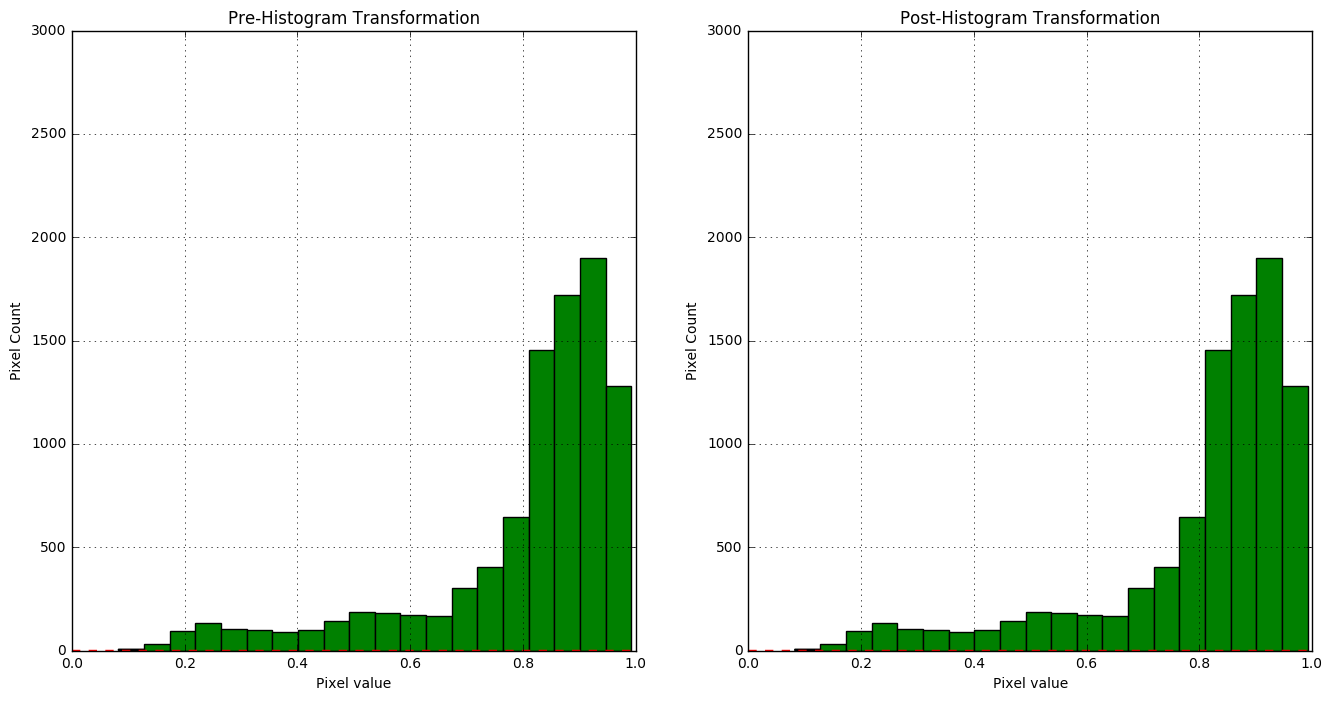

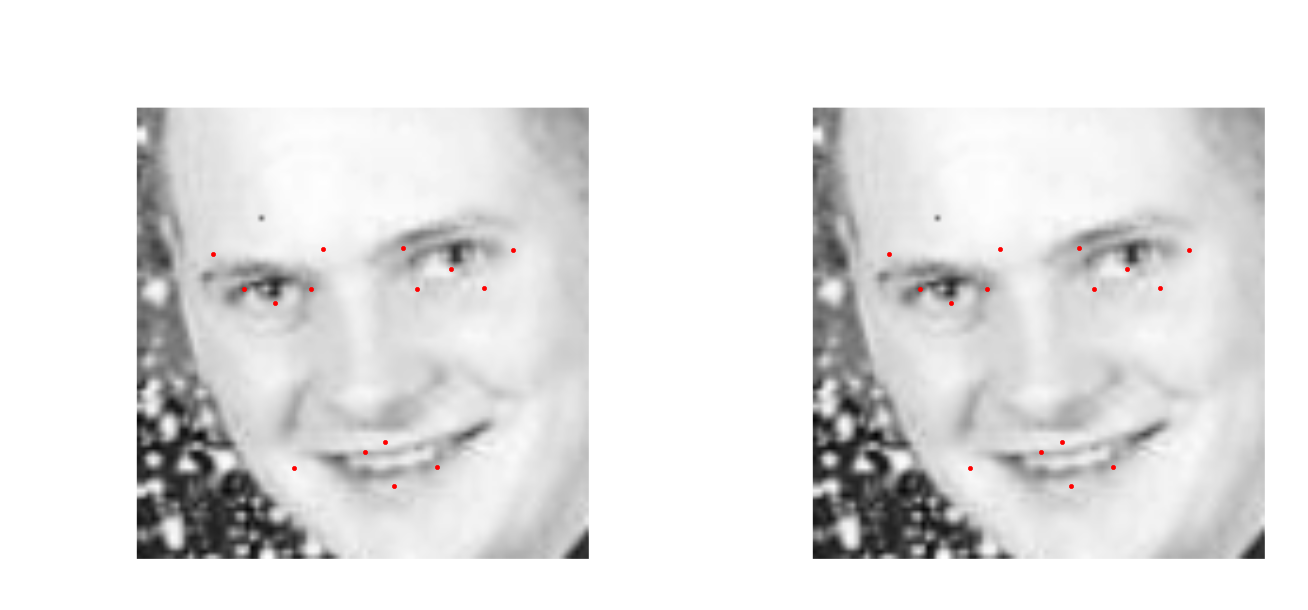

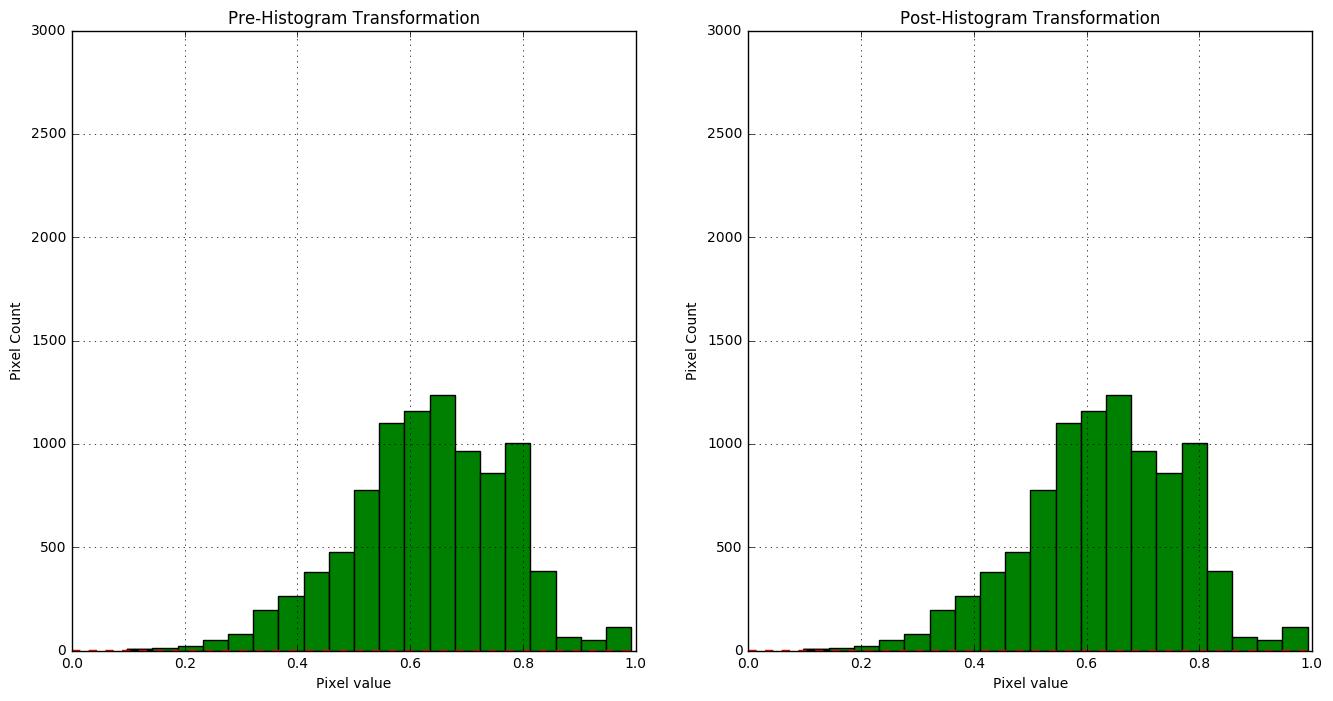

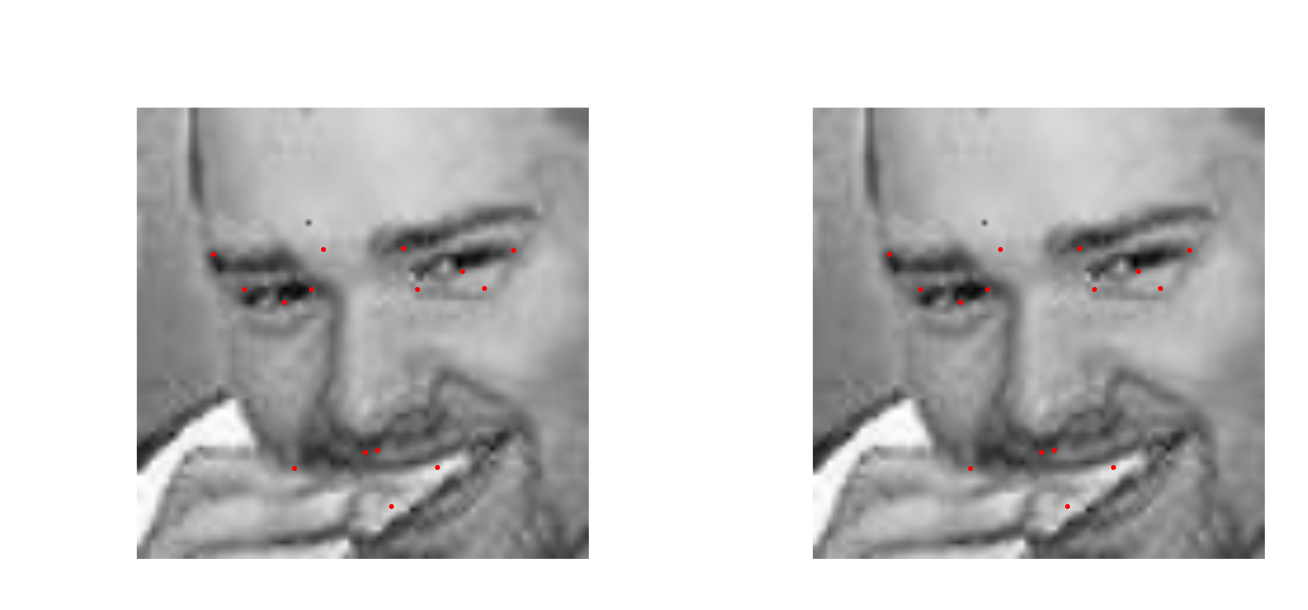

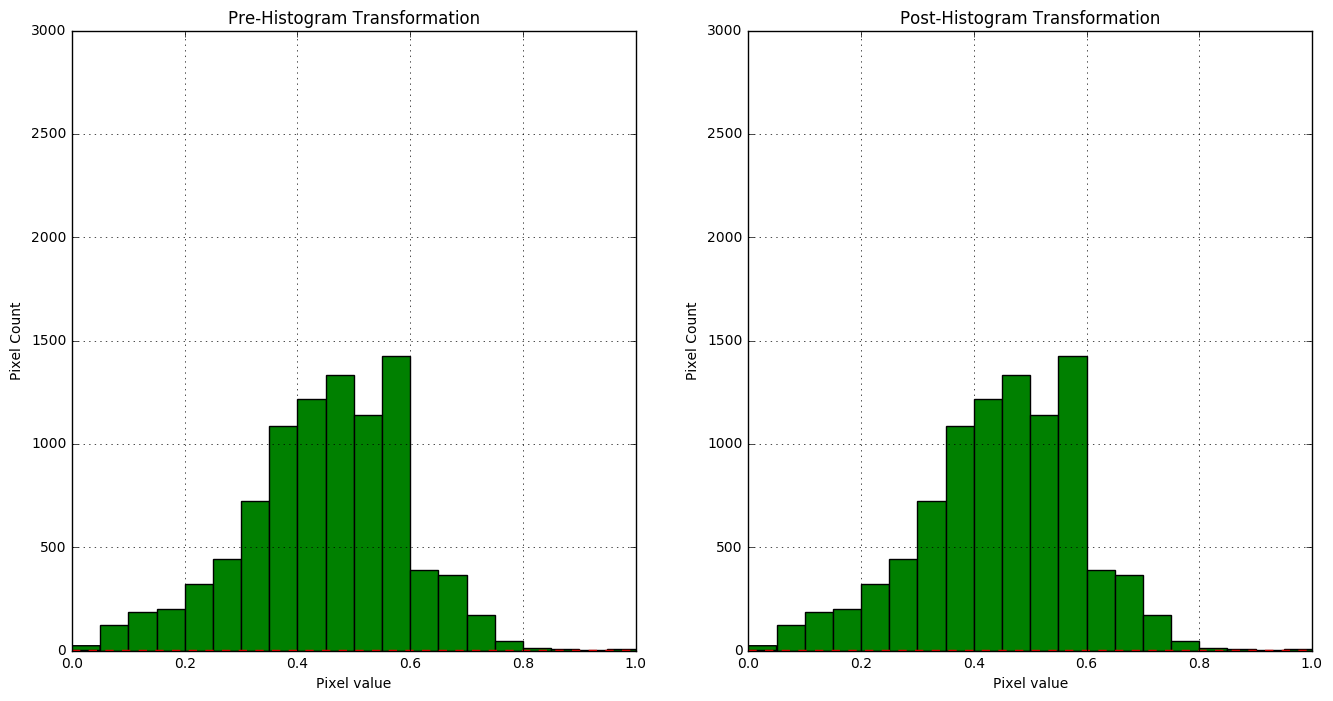

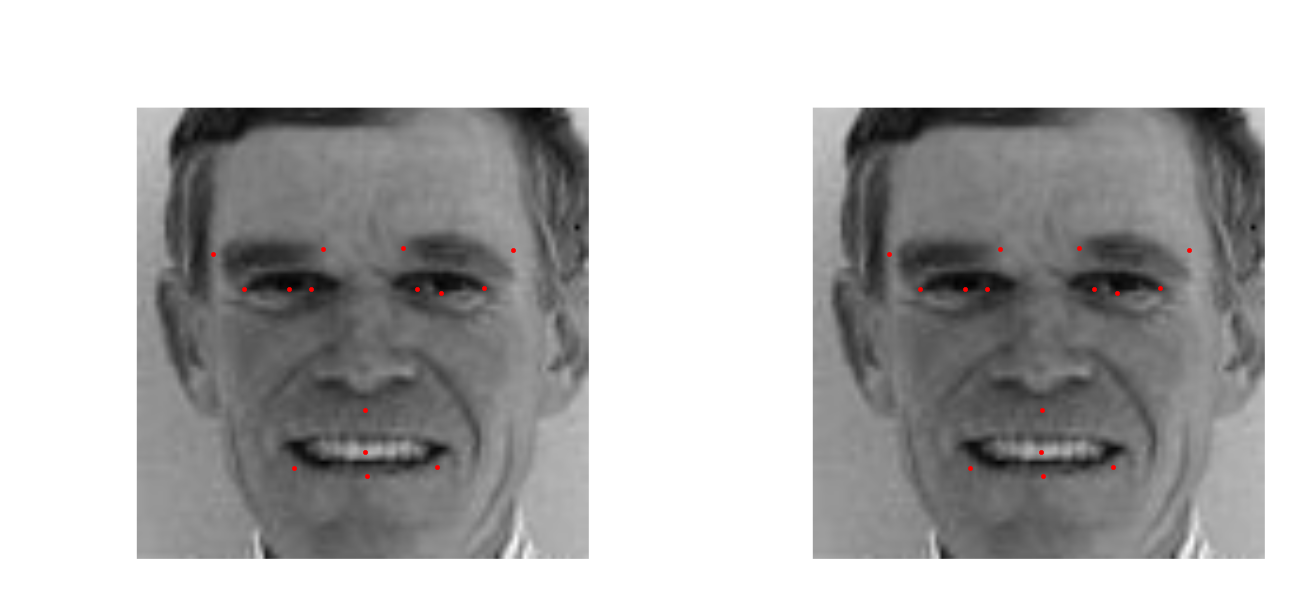

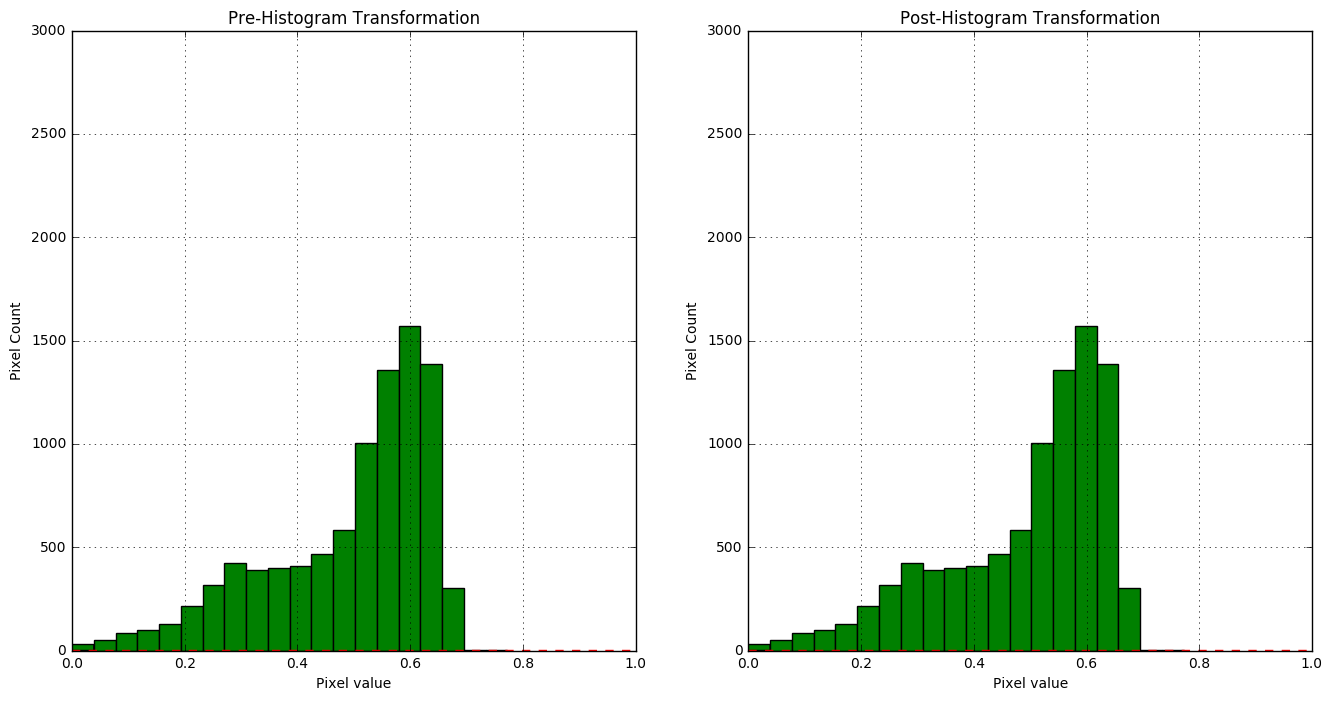

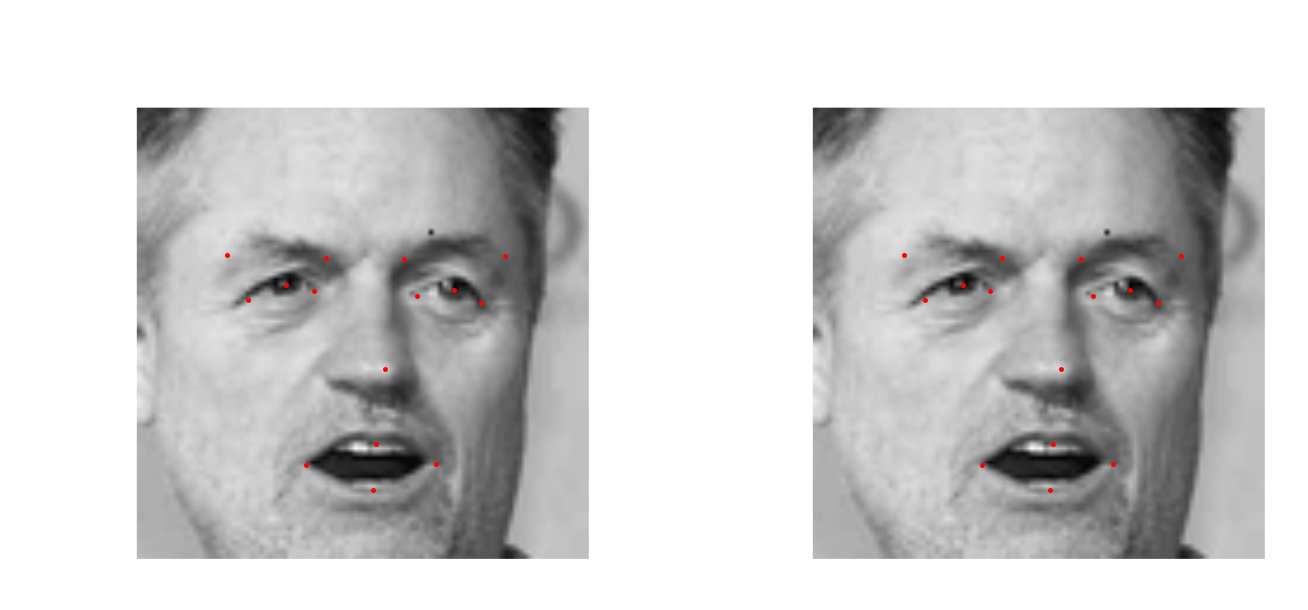

In [17]:
import copy
import math
# This function sets up the 9 bins for digitizing the data for a frame X
def setup_heatmap(X):
    bins = np.arange(0, 1.0, 0.111) # Set up 9 bins for holding data
    
    # digitize the incoming data into bins
    binplace = np.digitize(X, bins, right=True)
    
    # Flatten for vector processing
    binplace = binplace.flatten()
    
    # return the bins
    return binplace


def PreProcessFrame(data, labels, plot=False):

    X = process_image(data, labels, plot=plot)

    labels = labels * 48 + 48
    # Attach a color with each bin, in this case 9 colors, one for each bin
    # We are not interested in all colors, only the colors that highlight the eyes. 
    # so, make other cols "white" or do not show.
    # Deteremined through trial and error that bins 2 and 3 are the best bins for the eyes
    cmap = colors.ListedColormap(['white', 'white', 'orange', 'red', 'white', 'white', 'white', 'white', 'white'])
    bounds=[0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    return binplace, X, X_flattened, labels

def determine_eye_coordinates(eye_indices):
    
    # Two lists are needed to hold the pixels that 
    # represent each eye
    eye_1_pos = []
    eye_2_pos = []

    # The eyes are usually part of the dark pixels in the images
    # And dark pixels are captured in the lowest 3 digitized bins. Learned through 
    # trial and error by observing the heat maps of multiple images

    # Now extract the two eye sets
    # The eyes fall within rectangles defined by multiple rows and columns
    # Each pixel is represented by a (row * column) number 
    # Start the count from the top left of the photo
    # The two rectangles are through the observation of multiple images
    for item in eye_indices:
        if item > 2900 and item < 2920 or \
            item > 2996 and item < 3016 or \
            item > 3092 and item < 3112 or \
            item > 3188 and item < 3208 or \
            item > 3284 and item < 3304 or \
            item > 3380 and item < 3400 or \
            item > 3476 and item < 3496 or \
            item > 3572 and item < 3592 or \
            item > 3668 and item < 3688 or \
            item > 3764 and item < 3784 or \
            item > 3860 and item < 3880:
            
            eye_1_pos_int = item//96  # The whole number part is the row
            eye_1_pos_frc = item%96 # The fractional part is the column
            
            eye_1_pos_y = eye_1_pos_int # Use more distinguishing variables for y value
            eye_1_pos_x = eye_1_pos_frc # Use more distinguishing variables for x value
        
            # Add to a list that defines eye number 1
            eye_1_pos.append((eye_1_pos_x, eye_1_pos_y))
        
        # Do exactly the above for the second eye. Only the bounding rectangle is different
        elif item > 2939 and item < 2959 or \
            item > 3035 and item < 3055 or \
            item > 3131 and item < 3151 or \
            item > 3227 and item < 3247 or \
            item > 3323 and item < 3343 or \
            item > 3419 and item < 3439 or \
            item > 3515 and item < 3535 or \
            item > 3611 and item < 3631 or \
            item > 3707 and item < 3727 or \
            item > 3803 and item < 3823 or \
            item > 3899 and item < 3919:
                
            eye_2_pos_int = item//96
            eye_2_pos_frc = item%96
            
            eye_2_pos_y = eye_2_pos_int
            eye_2_pos_x = eye_2_pos_frc
        
            # List of pixels that define the second eye
            eye_2_pos.append((eye_2_pos_x, eye_2_pos_y))

    # Return the pixel coordinates of the 2 eye clusters
    return (eye_1_pos, eye_2_pos)


def VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging):
    # There is a possibility that the first chosen 2 bins do not have any eye pixel
    # Successively add a bin until there are non-zero data points in the eye rectangle
    # This is kludgy stuff - my apologies!
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Adding a bin")
        eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3))[0])
        eye_1, eye_2 = determine_eye_coordinates(eye_indices)
        if len(eye_1)==0 or len(eye_2)==0:
            if logging==True:
                print("Adding another bin")
            eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4))[0])
            eye_1, eye_2 = determine_eye_coordinates(eye_indices)
            if len(eye_1)==0 or len(eye_2)==0:
                if logging==True:
                    print("Adding yet another bin ")
                eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|(binplace==5))[0])
                eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                if len(eye_1)==0 or len(eye_2)==0:
                    if logging==True:
                        print("Adding the last 4 bins - the last attempt")
                    eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|\
                                        (binplace==5)|(binplace==6)|(binplace==7)|(binplace==8)|(binplace==9))[0])
                    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                    
    return(eye_1, eye_2)


def darken_eyes(frame, logging = False):

    X = np.reshape(frame,(96,96))

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    
    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])
    
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
    
    eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False)
    
    if logging == True:
        plt.figure(figsize=(8, 4))
        #print("process_image I")
        plt.imshow(np.reshape(frame,(96,96)), cmap = cm.gray) 
    
    # Eye1 1: For all known eye pixels, darken them by moving left
    for x in eye_1:
        frame[x[0]*x[1]] -= 0.2
        if frame[x[0]*x[1]] < 0:
            frame[x[0]*x[1]] = 0
    
    # Eye 2: For all known eye pixels, darken them by moving left
    for x in eye_2:
        frame[x[0]*x[1]] -= 0.2
        if frame[x[0]*x[1]] < 0:
            frame[x[0]*x[1]] = 0
    return frame

# Routine to loop through and darken all eyes in all images in training data
def darken_eyes_all(images, logging=False):
    for i in range(0, len(images)):
        images[i] = darken_eyes(images[i])
    return(np.array(images))

# IGNORE THIS ROUTINE FOR NOW, IT IS NOT USED
def enhance_critical_points(frame, attributes):

    # unscale the attribute form its -1, 1 boundaries
    attributes = attributes * 48 + 48

    #attribute = attribute[[6,7,10, 11, 20, 21, 22, 23, 24, 25]]
    attributes = attributes[[0,1]]
    #print(len(attribute))
    critical_pixels = [] * len(attributes)
    #attribute = attribute * 48 + 48
    for x, y in np.reshape(attributes,(len(attributes)/2, 2)):
        #print(x,y)
        critical_pixels.append(int((x*y)))
        #print("x, y is {}  {} {}".format(x,y, x*y))

    # Amount by which to increase the area around each critical point
    shift = 0.5

    # Go with a 10% threshold all around the critical points
    # Loop for every one of 10 ctitical features
    #for index in feature_index:
    count = 0
    for pixel_value in critical_pixels:
        z = frame[pixel_value]
        #print(z)
        if z-shift >= 0:
            frame[pixel_value] -= shift
        else :
            frame[pixel_value] = 0

        count += 1

    # Return the critical point enhanced frame 
    return np.array(frame).astype(np.float32)

cpe_dataset = repair_dataset(logging=False)
X_CPE, y_CPE = get_data(cpe_dataset, logging=False)

np.random.seed(22)
sample = np.random.rand(5) * len(X_CPE)

# IGNORE FOR NOW, NOT USED
for i in sample:
    before = X_CPE[i]
    #X_CPE_list = X_CPE[i].tolist()
    after = enhance_critical_points(X_CPE[i], y_CPE[i])
    compare_histograms(before, after)
    compare_images(before, y_CPE[i], after, y_CPE[i])
    
start = time.time()
cpe_train = np.array(map(enhance_critical_points, X_CPE, y_CPE))
stop = time.time()
print("Finished CPE processing in %4f seconds" % (stop - start))

# Routine to loop through and enhance all eyes in all images
def enhance_critical_points_all(frame=train_data, attributes=train_labels):
    train_enhanced_eyes = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_enhanced_eyes[index] = np.array(enhance_critical_points(train_data[index], attributes[index]))
    return np.array(train_enhanced_eyes)

start = time.time()
print("starting enhancement of eyes")
train_enhanced_eyes = enhance_critical_points_all(train_data, train_labels)
print("Finished enhancement of eyes in %4f seconds" % (time.time() - start))


# test the darken_eyes routime
test_images = [1940, 601]
for i in test_images:
    darken_eyes(train_data[i], logging = True)

## IMAGE ROTATION

In [23]:
# Given one frame and coordinates of its labels...
# 
# If "plot" is True, show the red dots on the image and return a 96 by 96 matrix
# If "plot" is False, just return a 96 by 96 matrix
def process_image(image, labels, plot=False): 

    if plot == True:
        labels = labels * 48 + 48
        plt.figure(figsize=(8, 4))
        #print("process_image I")
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray) 
        for x, y in np.reshape(labels,(len(labels)/2, 2)):
            plt.plot(x, y, 'r.')
        plt.axis('off')
        plt.show()
    return np.reshape(image,(96,96))


from math import *

def getAngleBetweenPoints(x_1, y_1, x_2, y_2):
    deltaY = y_2 - y_1
    deltaX = x_2 - x_1
    angle = atan2(deltaY, deltaX) # angle in radians
    
    # convert angle to degrees and return
    return angle * 180/pi


def rotate_point(centerPoint,point,angle):
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

def rotate_labels(labels, axis, angle):
    labels_rotated=[]

    for i in range(0, 30, 2):
        point=[labels[i], labels[i+1]]
        new_x, new_y = rotate_point(axis, point, angle)
        labels_rotated.append((new_x, new_y))
    return labels_rotated

from matplotlib import colors
from skimage import data
from skimage.transform import rotate

# Rotate the image
# "data" here is one image frame
def image_rotate(data=train_data[0], labels=train_labels[0], plot=False, logging = False):

    # ensure that the rotation direction is logged
    rotation_direction=1  # anti-clockwise by default
    angle = 0
    
    
    # Preprocess the data 
    binplace, X, X_flattened, labels = PreProcessFrame(data, labels, plot=plot)

    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])
    
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)

    loopIndex = 0
    shift = 0.2
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_left(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via darkening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error I - Image is too light")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    loopIndex = 0
    shift = 0.3
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_right(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via lightening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error II - too dark")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    # One last net to catch data where eye cannot be recognized
    # If there is a picture where no pixels appear in the eye rectangle,
    # we have no choice but to give up. I have not seen this happen. 
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Eye index is zero, sending back original data")
        return labels, X_flattened
    
    # I was not sure how an assignment of X into X_flattened would work, so I decided 
    # to make an explicit copy. I needed a copy because we are going to munge this
    # new frame with rotated pixel values. Start by initializing all pixels to 0
    Xcopy = X_flattened.copy()
    for i in X_flattened:
        Xcopy[i] = 0
        
    # The visual of having located the eye pixels and overlaying them on the original image is powerful
    # Plot the eye pixels on top of the original image
    if plot==True:
        plt.scatter(*zip(*eye_1))
        plt.scatter(*zip(*eye_2))
    
    if len(eye_indices) != 0:
        for element in eye_indices:
            Xcopy[element] = X_flattened[element]
    else:
        if logging==True:
            print("eye_indices is zero")

    # Reshape for further processing
    Xcopy = np.reshape(Xcopy,(96,96))

    # Put all the eye data together
    eye_1_x,eye_1_y=zip(*eye_1)
    eye_2_x,eye_2_y=zip(*eye_2)

    # Compute the centroid coordinates. There most likley is a better formula
    center_eye_1=sum(eye_1_x)/len(eye_1), sum(eye_1_y)/len(eye_1)
    center_eye_2=sum(eye_2_x)/len(eye_2), sum(eye_2_y)/len(eye_2)
    if logging==True:
        print("The centroid values are {} {}".format(center_eye_1, center_eye_2))

    # compute  the angle with the horizontal
    # using the coordinates of the 2 eyes
    angle = getAngleBetweenPoints(center_eye_1[0], center_eye_1[1], center_eye_2[0], center_eye_2[1])

    # Needs skimage imports
    if (center_eye_2[1] < center_eye_1[1]):
        #print("Anti clockwise rotation") because left eye is lower than the right eye, right eye is axis
        X_rotated = rotate(X, 360 - abs(angle), center = [center_eye_2[0], center_eye_2[1]], mode = 'symmetric',\
                                   resize = False, clip = True, preserve_range = True)
        #Rotate the labels
        if logging==True:
            print("C angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, [center_eye_2[0], center_eye_2[1]], -angle)
        angle = 360-angle
        rotation_direction=1

    else:
        #print("Anti clockwise rotation"), right eye is lower than the left eye, left eye is axis
        X_rotated = rotate(X, abs(angle), center =[center_eye_1[0], center_eye_1[1]], mode='symmetric',\
                                  resize = False, clip = True, preserve_range = True)
    
        #Rotate the labels
        if logging==True:
            print("AC angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, [center_eye_1[0], center_eye_1[1]], -angle)
        angle = -angle
        rotation_direction=0
        
    # Not sure why I check but I want  to make sure that we have an array of size 9216
    if X_rotated.flatten().shape[0] != 9216:
        if logging==True:
            print("Something wrong {}".format(X_rotated.flatten().shape[0]))

    # Return the rotated image and its parameters
    return rotated_labels, X_rotated.flatten()

def sample_rotate():
    # ROTATION 
    # The main calls are here
    np.random.seed(0)
    samples = np.floor(np.random.rand(5) * len(train_data))
    logging = False
    plot = True
    # For the training samples
    for sample in samples:
        # Rotate the images
        rotated_labels, rotated_image, angle, direction = image_rotate(data = train_data[sample], \
                                    labels = train_labels[sample], plot=plot, logging=logging)

        # show the original
        plt.imshow(np.reshape(train_data[sample],(96,96)), cmap = cm.gray)
        plt.show()

        # Now show the rotated image
        if rotated_image is not None:
            labels = np.array((np.array(rotated_labels) -48)/48)
            labels = labels.flatten()
            process_image(image = np.array(rotated_image), \
                          labels = labels, plot=True)
            

def train_rotate_all(train_data=train_data):

    logging = False
    start = time.time()
    if logging==True:
        print("Starting rotation of train_data at %4f seconds" % (time.time() - start))

    if logging==True:
        print(len(train_data))
    
    # allocate storage for results
    train_rotated = np.zeros((len(train_data), 9216))
    labels_rotated = np.zeros((len(train_data), 30))
    
    if logging==True:
        print(train_rotated.shape)

    for sample in range(0,len(train_data)):
        if logging==True:
            print(sample)

        rotated_labels, rotated_image = \
            image_rotate(data=train_shift_left[sample], labels=train_labels[sample], logging=logging)

        # Show some visual indication that processing is happening
        # This code can be removed
        if logging==True:
            if i > 0 and i%100 == 0:
                sys.stdout.write('&')
            else:
                sys.stdout.write('.')

        # Store the results
        train_rotated[sample] = np.array(rotated_image)
        labels_rotated[sample] = np.array(rotated_labels).flatten()

    # send the next output to the next line for aesthetic reasons
    if logging==True:
        sys.stdout.write('\n')


    # Final manipulation prior to returning data
    train_rotated_final = np.array(train_rotated)
    labels_rotated_final = np.array(labels_rotated)
    labels_rotated_final = (labels_rotated_final - 48)/48

    print("Finished rotating train_data at %4f, completed rotation in %4f seconds" % (time.time(), time.time() - start))
    
    # Done, return 4 fields
    return train_rotated_final, labels_rotated_final


# Rotate all images in training data
train_rotated, labels_rotated = train_rotate_all(train_data)

Finished rotating train_data at 1482562407.148531, completed rotation in 82.344937 seconds


Test: 0, 2139


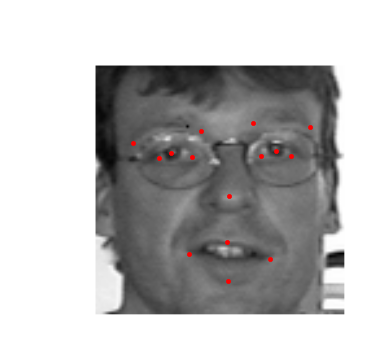

Worst: 1940


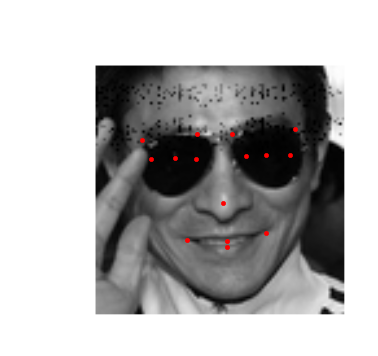

Bad: 504 and 601


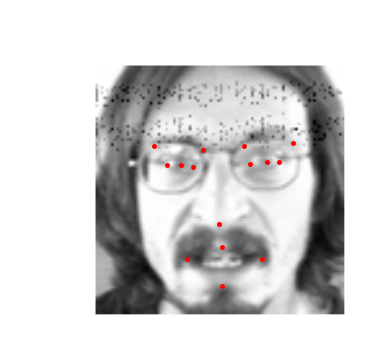

Salvageable: 40, 122, 326, 409, 565, 1278, 1356, 1615, 1653, 1676, 1763, 1948, 2024


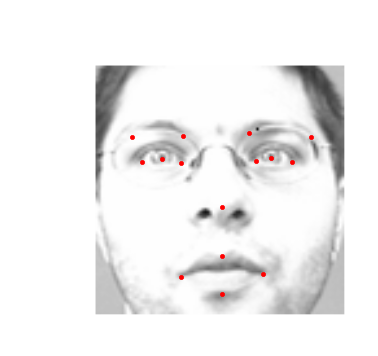

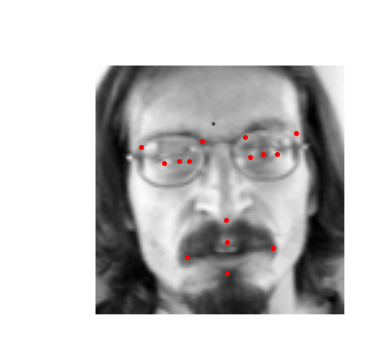

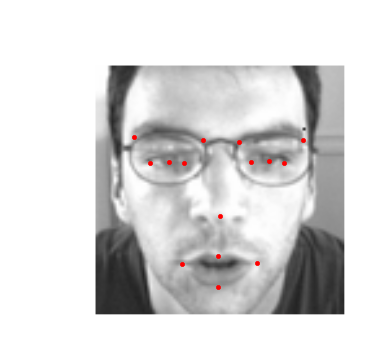

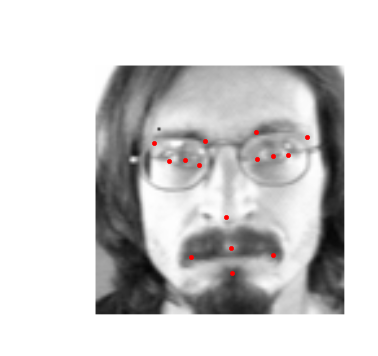

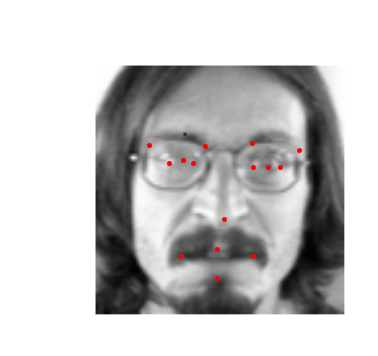

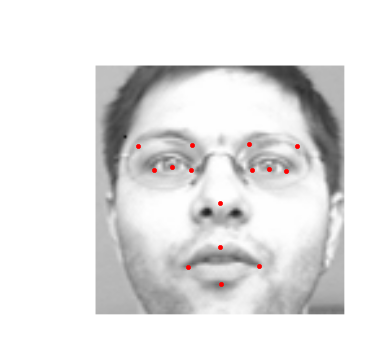

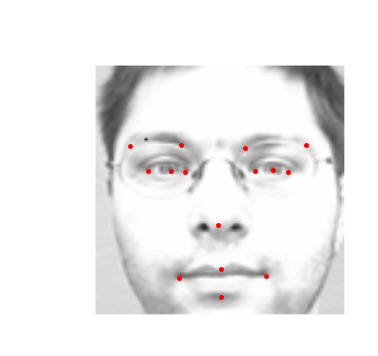

In [24]:
#test
print("Test: 0, 2139")
X = process_image(train_data[0], train_labels[0], plot=True)
X = process_image(train_data[2139], train_labels[2139], plot=True)

#worst
print("Worst: 1940")
X = process_image(train_data[1940], train_labels[1940], plot=True)

# Bad
print("Bad: 504 and 601")
X = process_image(train_data[504], train_labels[504], plot=True)
X = process_image(train_data[601], train_labels[601], plot=True)

#Salvageable
print("Salvageable: 40, 122, 326, 409, 565, 1278, 1356, 1615, 1653, 1676, 1763, 1948, 2024")
X = process_image(train_data[40], train_labels[40], plot=True)
X = process_image(train_data[122], train_labels[122], plot=True)
X = process_image(train_data[326], train_labels[326], plot=True)
X = process_image(train_data[409], train_labels[409], plot=True)
X = process_image(train_data[565], train_labels[565], plot=True)
X = process_image(train_data[1278], train_labels[1278], plot=True)
X = process_image(train_data[1356], train_labels[1356], plot=True)
X = process_image(train_data[1615], train_labels[1615], plot=True)
X = process_image(train_data[1653], train_labels[1653], plot=True)
X = process_image(train_data[1676], train_labels[1676], plot=True)
X = process_image(train_data[1763], train_labels[1763], plot=True)
X = process_image(train_data[1948], train_labels[1948], plot=True)
X = process_image(train_data[2024], train_labels[2024], plot=True)


## STEP 4 : Look at Dimensionality Reduction using PCA

In [ ]:
def P1():
### STUDENT START ###
    components = [2, 4, 8, 10, 15, 20, 25, 30]
    
    count = 0
    for n_components in components:
        count += 1
        pca = PCA(n_components = n_components, copy = True, whiten = False)
    
        # Case I - Original Raw Data
        pca.fit(train_data)
        X_data = np.arange(1, n_components, 1)

        Y_data = pca.explained_variance_ratio_[0:n_components-1]
        Y_data = np.cumsum(Y_data)

        plt.figure(figsize = (10, 10))
        plt.subplot(8,1,count)

        # Plot cumulative variance for original raw data
        plt.title("Cumulative Variance - Raw original data")
        plt.plot(X_data, Y_data, '--bo')
        plt.xlabel("Numbered Components")
        plt.ylabel("Cumulative variance")
        plt.annotate('85% cumulative\n variance', xy=(80, 0.9), xytext = (42, 0.9), arrowprops=dict(arrowstyle="->"))
    
    ### STUDENT END ###

P1()

### Conclusion from PCA analysis

Covariance convergence level is at the 75% level with 30 features. This is seen with the original data and one version of adjusted data (histogram shifted). 

Because covariance is still at 75% with 30 features, dimensionality reduction will not be attempted. 

Loading test data and running a prediction on it using the single layer Neural Network. Plotting the predictions to get a visual analysis of good/bad our model is.

In [ ]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, y = load(test=True)
y_pred = net1.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i*4+1], y_pred[i*4+1], ax)

plt.show()

## STEP 5: Convolutional Neural Network

Moving back to our original data, 

In [ ]:
cnet1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=400,
    verbose=1,
    )

rotated_data_2d = train_rotated.reshape(len(train_rotated), 1, 96, 96)

cnet1.fit(rotated_data_2d, labels_rotated)


# Currently on training for 10 epochs
# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
# with open('net2.pickle', 'wb') as f:
#     pickle.dump(net2, f, -1)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00276) * 48))

## Graph results for Convolutional Neural Net

Plot how the training did for the 10 epochs. This plot will be interesting when we run it for 400 epochs as we did for Neural Networks.

In [ ]:
graph_results(cnet1)

In [ ]:
sample1 = load(test=True)[0][100:101]
sample2 = load2d(test=True)[0][100:101]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2[0], y_pred2, ax)
plt.show()

## Update learning rates
Convolutional Net 2 - instead of using static learning rates and momentums, we can use lasagne's "on epoch finshed" call to take a function that will adjust our learning rates and momentum dyanimcally after each epoch. Nesterov's momentum add's the gradient at the current point, plus the velocity, which provides some look ahead in the data to improve optimization. By increasing momentum during training, Geoffrey Hitton has shown this can imrove optimization.

#### ref: http://www.cs.toronto.edu/~hinton/absps/momentum.pdf

In [ ]:
train_data_2d = train_data.reshape(len(train_data), 1, 96, 96)

#in order to change the learning rates and momemtum, we need to make it a shared variable in theano.
#http://lasagne.readthedocs.io/en/latest/user/layers.html
import theano

def float32(var):
    return np.cast['float32'](var)

#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

start_time = time.time()
cnet2.fit(train_data_2d, train_labels)
print('CNN training completed in',(time.time()-start_time))

# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
# with open('cnet2.pickle', 'wb') as f:
#     pickle.dump(cnet2, f, -1)
    
graph_results(cnet2)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00157) * 48))

## Continue tweaking

The net above performed really well.  Let's see if we can continue to improve by adding more layers

In [ ]:
cnet3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    hidden5_num_units=500, hidden6_num_units=500, hidden7_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

cnet3.fit(train_data_2d, train_labels)
graph_results(cnet3)

In [ ]:
# Print RMSE
print("RMSE: %f" % (np.sqrt(0.00152) * 48))

## Using transformed data in the convolutional neural net.

Cnet 3 was the best run yet, but it was very slow compared to cnet2, which is almost as accurate. So to test the transformed data, we'll use the cnet2.

In [ ]:
#  Move transformations into 2d
stretch2d = train_stretched.reshape(len(train_stretched), 1, 96, 96)
shift2d = train_shift.reshape(len(train_shift), 1, 96, 96)
blur2d = train_blur.reshape(len(train_blur), 1, 96, 96)


cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(train_data_2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(stretch2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(shifth2d, train_labels)
graph_results(cnet2)

cnet2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=50,
    verbose=1,
    )

cnet2.fit(blur2d, train_labels)
graph_results(cnet2)



In [ ]:
print("Starting the generation of composite data")
transformed_data = stretch_histogram_all(train_data)
print(transformed_data.shape)
print("Finished stretching. Starting left shift")
transformed_data = shift_histogram_left_all(transformed_data)
print(transformed_data.shape)
print("Finished shifting. Starting blur")
transformed_data = apply_blur_all(transformed_data)
print(transformed_data.shape)
print("Darkening eyes")
transformed_data = darken_eyes_all(transformed_data)
print("Finished darkening eyes")
print("Finished blur. Starting rotation")
transformed_data, transformed_labels = train_rotate_all(transformed_data)
print(transformed_data.shape)
print("Done generating composite data")

In [ ]:
transformed_data_2d = transformed_data.reshape(len(transformed_data), 1, 96, 96)

cnet5 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(np.float32(0.03)),
    update_momentum=theano.shared(np.float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=400,
    verbose=1,
    )

cnet5.fit(transformed_data_2d, transformed_labels)
graph_results(cnet5)

## Keypoints detection in test data

In [ ]:
# Transforming test dataset by applying stretch/shift histogram
# and gaussian blur.
test_transformed= np.array(map(stretch_histogram, test_data))
test_transformed= np.array(map(shift_histogram, test_transformed))
test_transformed= np.array(map(apply_blur, test_transformed))

In [ ]:
from random import randint

test_data_2d = test_transformed.reshape(len(test_transformed), 1, 96, 96)
test_pred = cnet5.predict(test_data_2d) 

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_data))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_data[test_idx], test_pred[test_idx], ax)

plt.show()

## FUTURE

### Future: Median Angle Minimization (MAM) Transformation

Centering of a given face with respect to face inherent features is something that our team will study next. By overlaying two independently swiveling orientation triangles on the face and by using medians as the features and by using a transformation to reduce the angle betwen the medians to 0, we hope to better center the face so that prediction algorithmns have a higher degree of accuracy. Figue below captures the basic scheme of Centroids and inter-centoid Angle Measurement

<img src="MAX.png",width=500,height=500>

### Future: Critical Pixel Enhancement (CPE) Transformation + MAM Transformation

A combination of face centering, along with pixel enhancement, at the 6 vertices of the 2 critical orientation 
triangles is also in the future. By enhancing pixel intensity in 5% delta (pixel radius) circles, we hope to highlight
the vertices and hence facilitate better centering and recognition. 

<img src="PET.png",width=500,height=500>